# Classification Datasets from UCI Machine Learning Repository

This notebook provides details about five classification datasets from the UCI Machine Learning Repository.

## Datasets

### 1. Seeds Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt](https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt)
- **Business Domain**: Biology
- **Size**: 210 Instances, 7 Features

### 2. Iris Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)
- **Business Domain**: Biology
- **Size**: 150 Instances, 4 Features

### 3. Adult Income Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data)
- **Business Domain**: Socioeconomic
- **Size**: 48842 Instances, 14 Features

### 4. Heart Disease Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data)
- **Business Domain**: Healthcare
- **Size**: 303 Instances, 13 Features

### 5. Wine Dataset
- **URL**: [https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data)
- **Business Domain**: Chemistry
- **Size**: 178 Instances, 13 Features


# Pipeline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.cluster import KMeans

In [3]:
def connect_to_data_source(data_source, column_names = None):
    """
    Connects to the specified data source and returns a Pandas DataFrame.
    
    Parameters:
    - data_source: str, path to the data source or URL
    
    Returns:
    - df: pandas DataFrame containing the data
    """
    # Example: connecting to a CSV file

    if data_source.endswith('.txt'):
        df = pd.read_csv(data_source, sep="\s+", names=column_names)
    elif data_source.endswith('data'):
        df = pd.read_csv(data_source, header=None, names=column_names)
    elif data_source.endswith('.csv'):
        df = pd.read_csv(data_source)
    else:
        raise ValueError("Unsupported data source format.")
    
    return df



In [4]:
def clean_data(df, columns_to_drop=None, threshold=0.5):
    """
    Cleans the input DataFrame by removing missing values, data entry errors, unnecessary columns, and rows.
    
    Parameters:
    - df: pandas DataFrame, input data
    - columns_to_drop: list, optional, columns to be dropped
    - threshold: float, optional, threshold for missing values, columns with missing values exceeding this threshold will be dropped
    
    Returns:
    - cleaned_df: pandas DataFrame, cleaned data
    """
    
    # Drop specified columns
    if columns_to_drop is not None:
        df = df.drop(columns=columns_to_drop)
    
    # Drop rows with any missing values
    df.dropna(inplace=True)

    # Drop duplicate instances 
    df = df.drop_duplicates()
    
    return df


In [5]:
# Creating a sample DataFrame with missing values
data = {
    'A': [1, 2, None, 4, 5],
    'B': ['foo', None, 'bar', 'baz', None],
    'C': ['a', 'qux', 'quux', None, 'corge']
}

df = pd.DataFrame(data)

df = clean_data(df)

In [6]:


def data_transformation(df, categorical_features=None, numerical_features=None):
    """
    Perform data transformation including feature renaming,
    one-hot encoding for categorical features, and z-score standardization
    for numerical features.

    Parameters:
        df (DataFrame): The input DataFrame.
        categorical_features (list): List of categorical feature names.
        numerical_features (list): List of numerical feature names.

    Returns:
        DataFrame: Transformed DataFrame.
    """
    # If feature lists are not provided, automatically identify them
    if categorical_features is None or numerical_features is None:
        numerical_features = df.iloc[:,:-1].select_dtypes(include=['number']).columns.tolist()
        categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    label_encoder = LabelEncoder()
    # Perform one-hot encoding for categorical features
    for feature in categorical_features:
        df[feature] = label_encoder.fit_transform(df[feature])

    # Perform z-score standardization for numerical features
    for feature in numerical_features:
        mean = df[feature].mean()
        std = df[feature].std()
        df[feature] = (df[feature] - mean) / std

    return df


In [7]:
def perform_eda(df, numerical_features=None):
    """
    Perform exploratory data analysis including the 5-number summary,
    histograms, and boxplots for numerical variables.

    Parameters:
        df (DataFrame): The input DataFrame.
        numerical_features (list): List of numerical feature names.

    Returns:
        None
    """
    if numerical_features is None:
        numerical_features = df.select_dtypes(include=['number']).columns.tolist()

    # 5-number summary
    summary = df[numerical_features].describe().transpose()
    print("5-Number Summary:")
    print(summary)

    # Histograms and Boxplots
    for feature in numerical_features:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Histogram of {feature}')

        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[feature])
        plt.title(f'Boxplot of {feature}')

        plt.tight_layout()
        plt.show()

In [8]:
def manual_data_splitting(X, y, test_size=0.2, random_state=42):
    """
    Perform manual train-validation-test split on the data.

    Parameters:
    - X: Features DataFrame
    - y: Target Series
    - test_size: Size of the test set (default is 0.2)
    - random_state: Random seed for reproducibility (default is 42)

    Returns:
    - X_train: Training features
    - X_test: Test features
    - y_train: Training target
    - y_test: Test target
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test
    

In [9]:


def model_selection(X, y, problem_type='classification', test_size=0.2, random_state=None):
    """
    Perform model selection using LazyPredict.

    Parameters:
    - X: Feature matrix
    - y: Target variable
    - problem_type: Type of the problem, either 'classification' or 'regression'
    - test_size: The proportion of the dataset to include in the test split
    - random_state: Controls the shuffling applied to the data before splitting

    Returns:
    - models: A DataFrame containing information about the models and their performance
    """

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if problem_type == 'classification':
        # LazyClassifier for classification
        clf = LazyClassifier(predictions=True)
        models, _ = clf.fit(X_train, X_test, y_train, y_test)
    elif problem_type == 'regression':
        # LazyRegressor for regression
        reg = LazyRegressor(predictions=True)
        models, _ = reg.fit(X_train, X_test, y_train, y_test)
    else:
        raise ValueError("Invalid problem_type. Use 'classification' or 'regression'.")

    return models

In [10]:


def model_training(model, params, X_train, y_train, cv=5):
    """
    Train the model using Grid Search for hyperparameter tuning.

    Parameters:
    - model: The machine learning model object (e.g., RandomForestClassifier())
    - params: Dictionary containing hyperparameters to tune
    - X_train: Training features
    - y_train: Training labels
    - cv: Number of cross-validation folds

    Returns:
    - best_model: Trained model with best hyperparameters
    """

    grid_search = GridSearchCV(model, params, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    return best_model

# Example usage:
# best_model = model_training(RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, None]}, X_train, y_train, cv=5)


In [11]:


def model_evaluation(model, X, y):
    """
    Function to evaluate the model
    """
    y_pred = model.predict(X)
    print("Accuracy:", accuracy_score(y, y_pred))
    print(classification_report(y, y_pred))
    # Additional metrics for classification
    # Example: ROC-AUC
    try:
        print("ROC-AUC Score:", roc_auc_score(y, y_pred))
        fpr, tpr, _ = roc_curve(y, y_pred)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
    except:
        pass
    plt.show()

In [12]:
def handle_outliers(df, threshold=1.5):
    """
    Handle outliers by replacing their value with the mean of the respective column.
    This function only handles numeric columns.

    Parameters:
    - df: DataFrame containing the data
    - threshold: Threshold for detecting outliers (default is 1.5)

    Returns:
    - DataFrame with outliers replaced by mean
    """
    # Copy the DataFrame to avoid modifying the original DataFrame
    df_copy = df.copy()
    
    # Get only numeric columns
    numeric_columns = df_copy.select_dtypes(include=['number']).columns
    
    # Calculate the first quartile (Q1) and third quartile (Q3) for each numeric column
    Q1 = df_copy[numeric_columns].quantile(0.25)
    Q3 = df_copy[numeric_columns].quantile(0.75)
    
    # Calculate the interquartile range (IQR) for each numeric column
    IQR = Q3 - Q1
    
    # Identify outliers for each numeric column using the IQR method
    for col in numeric_columns:
        outlier_mask = (df_copy[col] < (Q1[col] - threshold * IQR[col])) | (df_copy[col] > (Q3[col] + threshold * IQR[col]))
        
        # Replace outliers with the mean of the respective column
        df_copy.loc[outlier_mask, col] = df_copy[col].mean()
    
    return df_copy

In [13]:
def master(url, column_names = None, problem_type='classification', model = None, params = None):
    """
    Master function to execute the workflow sequence of functions with defined input parameters.
    
    Parameters:
    data_source (str): File path or URL to the data source.
    algorithms (list): List of available algorithms.
    
    Returns:
    dict: Results of the master workflow.
    """
    
    # Data Collection
    data = connect_to_data_source(url, column_names)

    # Data Cleaning
    data = clean_data(data)

    # Data Transformation
    data = data_transformation(data)

    perform_eda(data) # Exploratory Data Analysis

    # Outlier Handling
    data = handle_outliers(data)
    
    try:
        data = data.data
        X = data.features
        y = data.targets.values
    except:

        X = data.drop([column_names[-1]], axis = 1)
        y = data[column_names[-1]].values
    
    # Manual Data Splitting
    X_train, X_test, y_train, y_test = manual_data_splitting(X, y, test_size=0.2, random_state=42)
    
    # Model Selection
    if model == None:
        trained_model = model_selection(X, y, test_size=0.2, random_state=42)
    else:
        selected_model = model
    # Model Training
    trained_model = model_training(selected_model, params, X_train, y_train)

    # Model Evaluation
    evaluation_results = model_evaluation(trained_model, X_test, y_test)
    
    
    
    return evaluation_results

# Seeds Dataset

The **Seeds Dataset** is a collection of measurements of geometrical properties of kernels belonging to three different varieties of wheat: Kama, Rosa, and Canadian². Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository²
- **Subject Area**: Biology²
- **Associated Tasks**: Classification, Clustering²
- **Feature Type**: Real²
- **Instances**: 210²
- **Features**: 7²

The seven geometric parameters of wheat kernels measured are²:

1. Area (A)
2. Perimeter (P)
3. Compactness (C = 4*pi*A/P^2)
4. Length of kernel
5. Width of kernel
6. Asymmetry coefficient
7. Length of kernel groove

All of these parameters are real-valued continuous².

The dataset can be used for the tasks of classification and cluster analysis². Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information².

Source: Conversation with Bing, 20/02/2024
(1) Seeds - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/seeds.
(2) seeds dataset | Kaggle. https://www.kaggle.com/datasets/rwzhang/seeds-dataset.
(3) Finding data in SEED | SEED Portal. https://www.seed.nsw.gov.au/need-help/finding-data-on-dataset-catalogue/finding-data-seed.
(4) SEED Dataset - SJTU. https://bcmi.sjtu.edu.cn/home/seed/.

5-Number Summary:
                         count  mean  std   min   25%   50%  75%  max
Area                    210.00 -0.00 1.00 -1.46 -0.89 -0.17 0.84 2.18
Perimeter               210.00  0.00 1.00 -1.65 -0.85 -0.18 0.88 2.06
Compactness             210.00  0.00 1.00 -2.66 -0.60  0.10 0.71 2.00
Length_of_kernel        210.00 -0.00 1.00 -1.65 -0.83 -0.24 0.79 2.36
Width_of_kernel         210.00 -0.00 1.00 -1.66 -0.83 -0.06 0.80 2.05
Asymmetry_coefficient   210.00 -0.00 1.00 -1.95 -0.76 -0.07 0.71 3.16
Length_of_kernel_groove 210.00 -0.00 1.00 -1.81 -0.74 -0.38 0.95 2.32
Class                   210.00  2.00 0.82  1.00  1.00  2.00 3.00 3.00


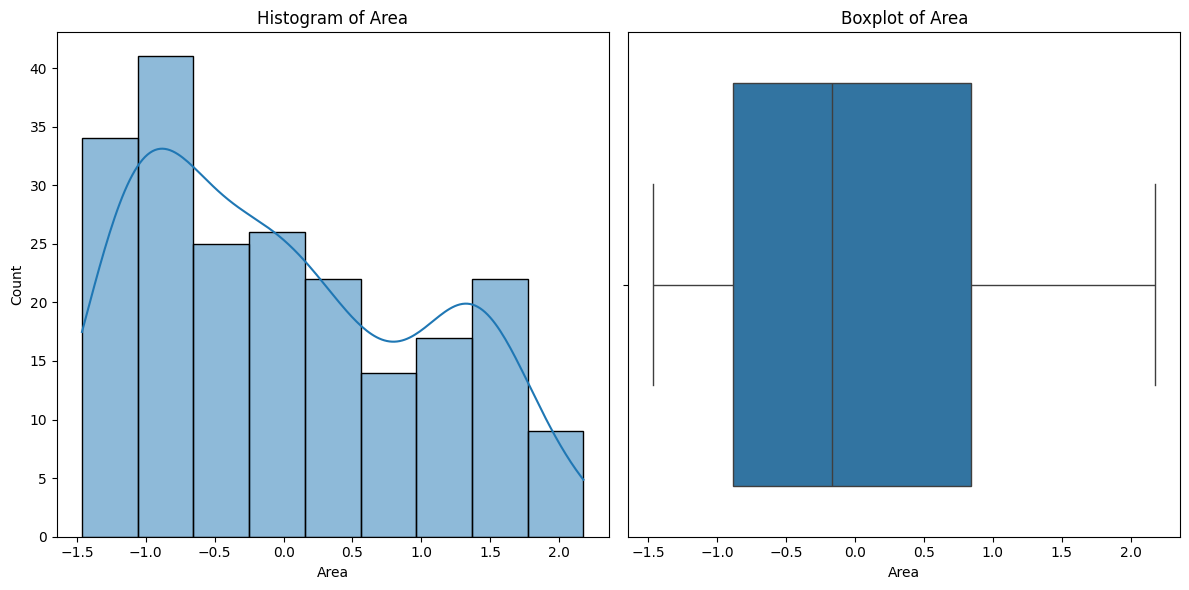

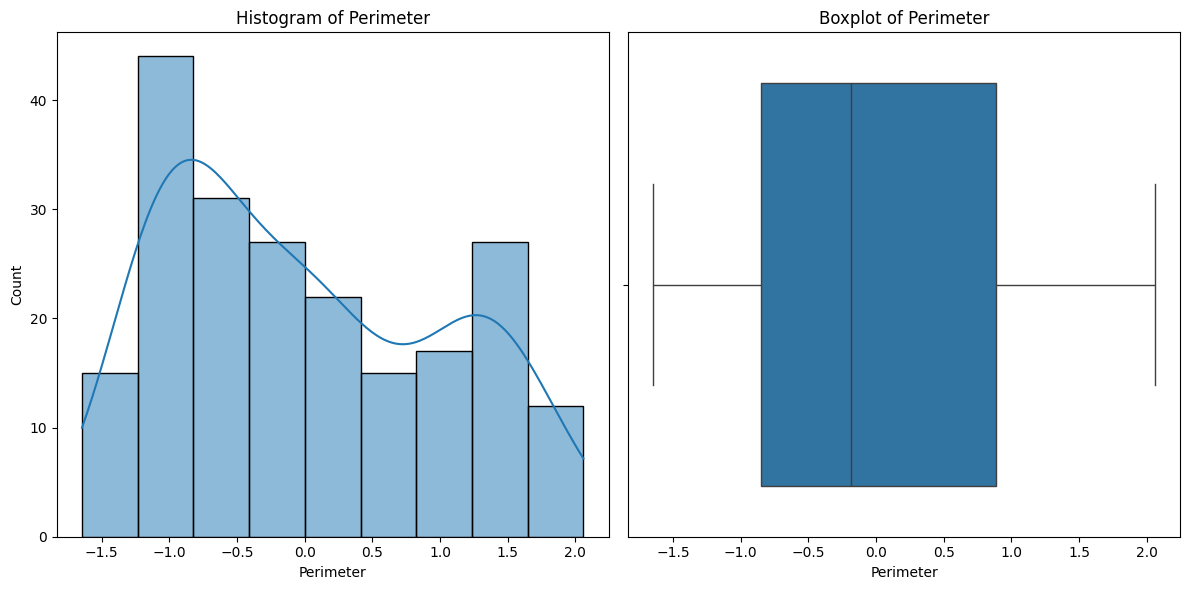

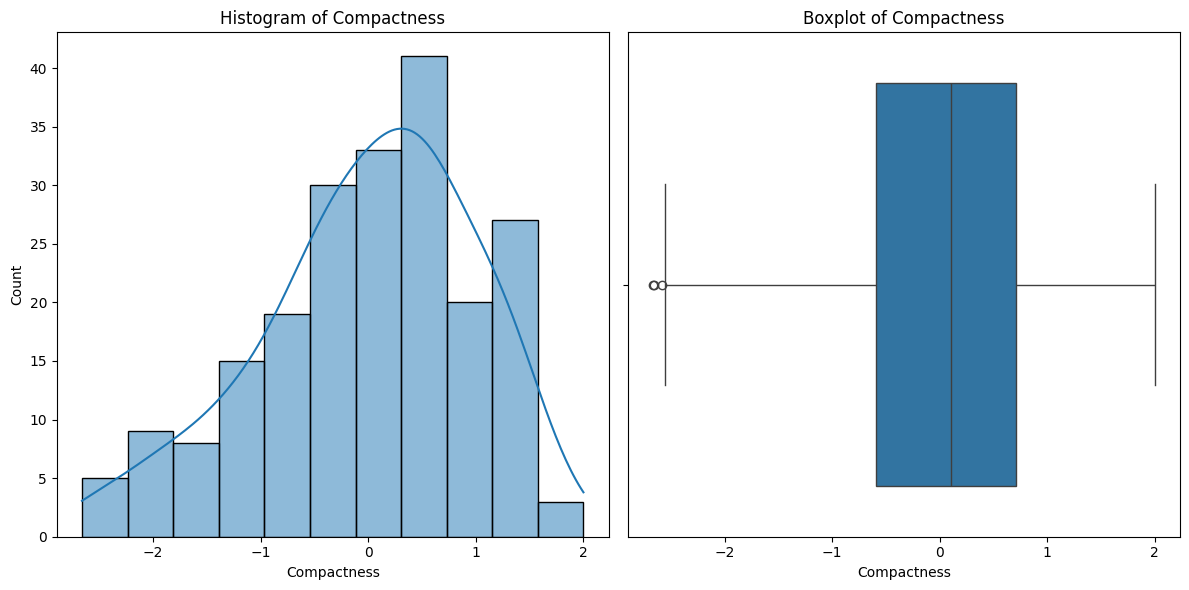

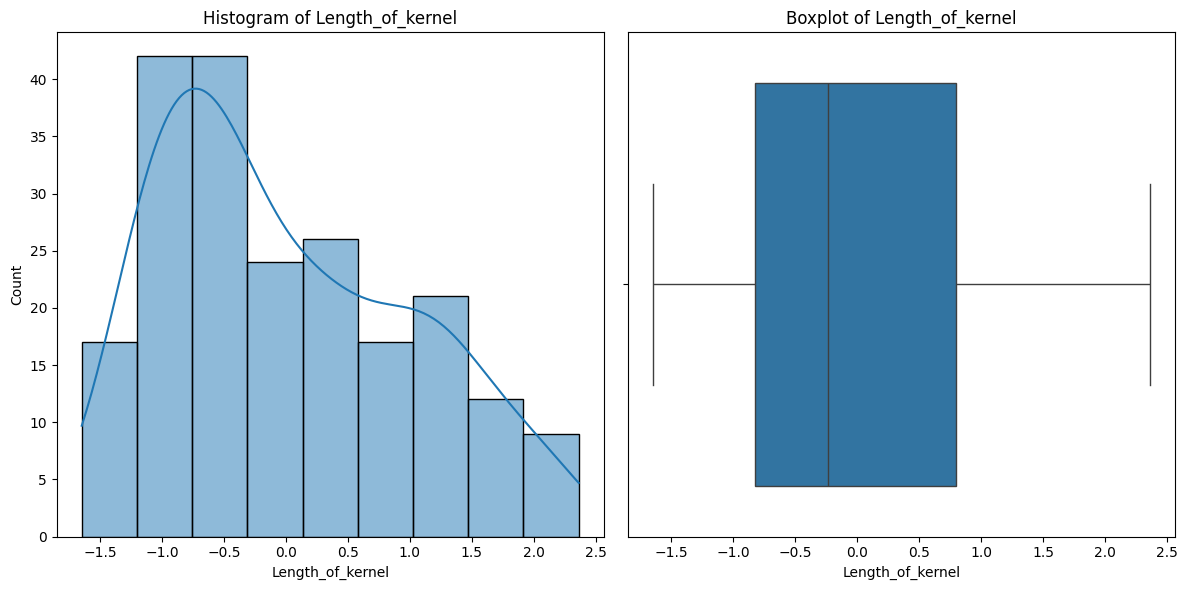

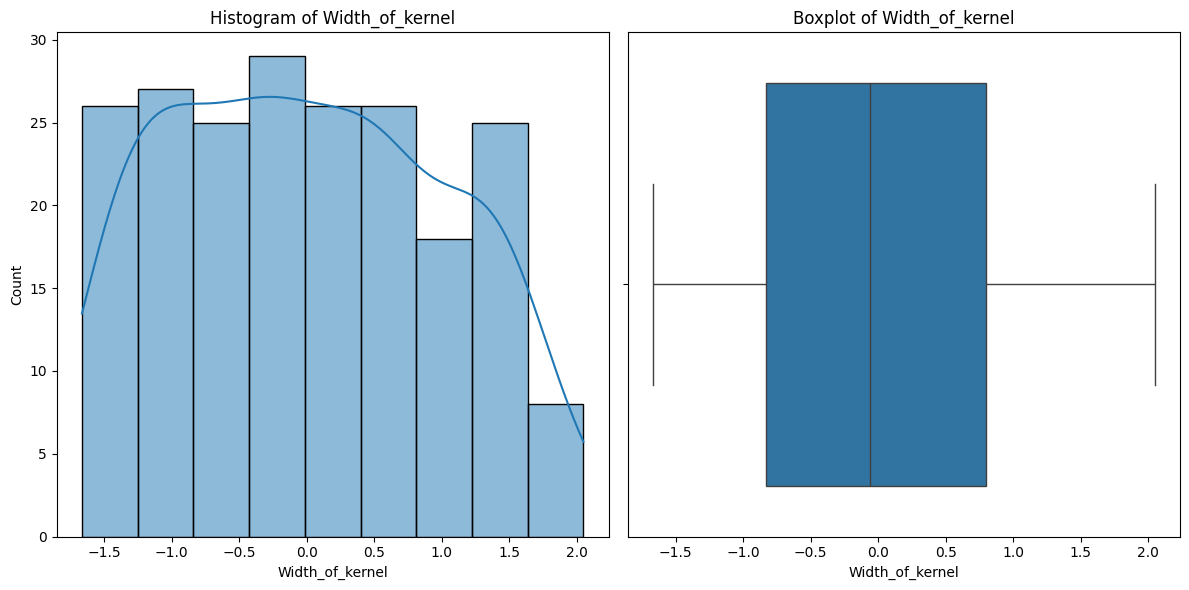

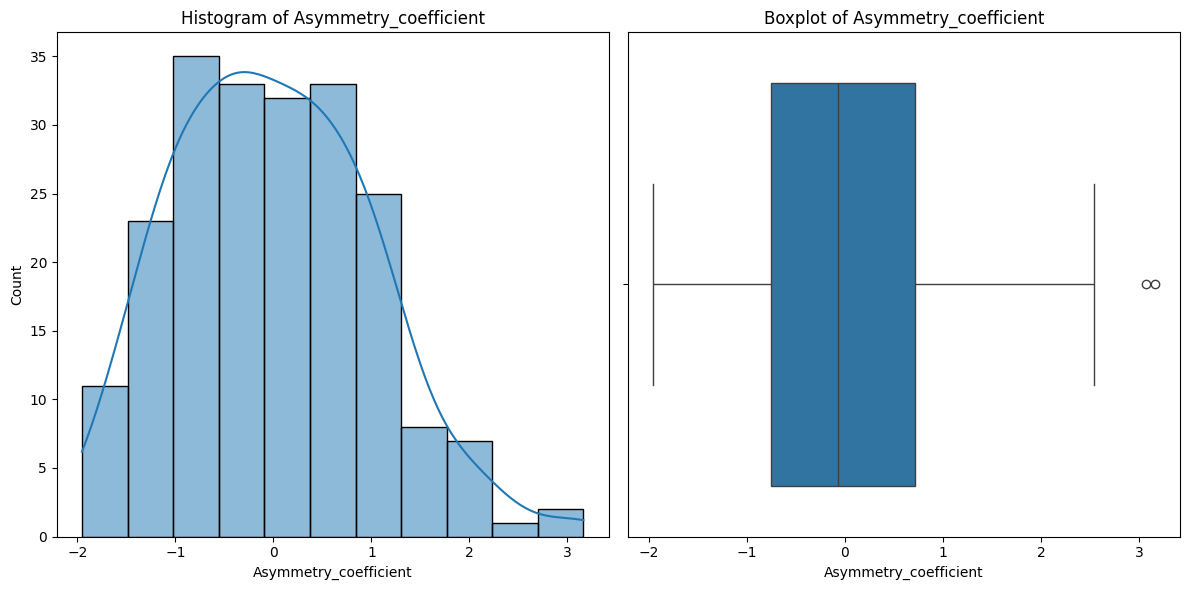

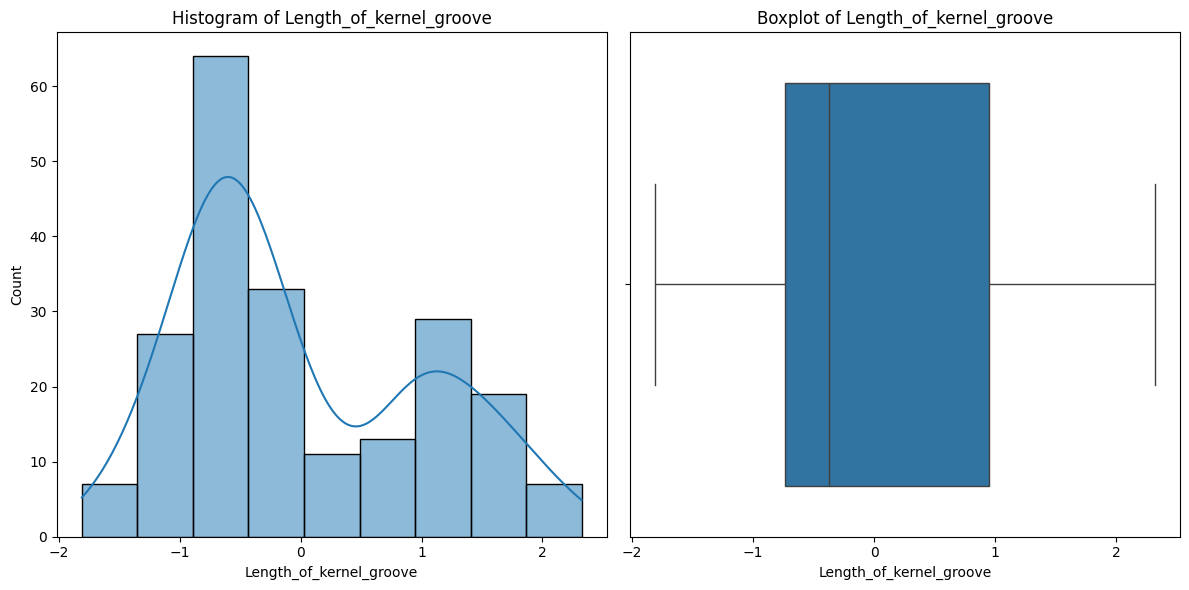

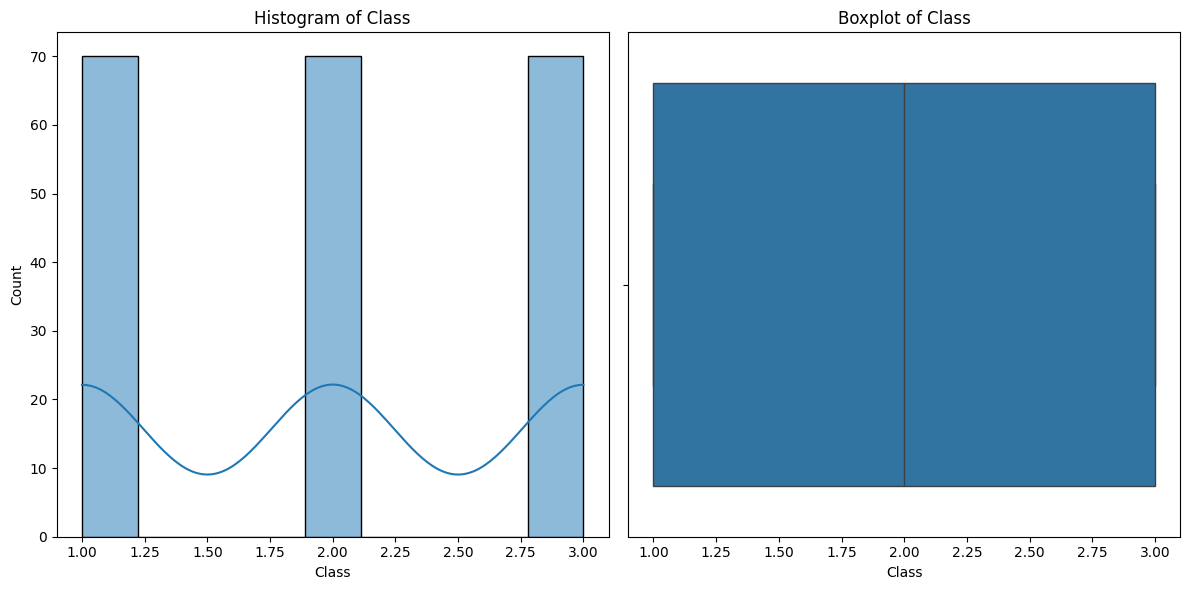

Accuracy: 0.07142857142857142
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.13      0.18      0.15        11
           2       0.07      0.07      0.07        14
           3       0.00      0.00      0.00        17

    accuracy                           0.07        42
   macro avg       0.05      0.06      0.06        42
weighted avg       0.06      0.07      0.06        42



In [14]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"
model = KMeans()
params = {'n_clusters':[3]}
column_names = ['Area', 'Perimeter', 'Compactness', 'Length_of_kernel', 'Width_of_kernel', 'Asymmetry_coefficient', 'Length_of_kernel_groove', 'Class']
master(url, column_names=column_names, problem_type='classification',model=model, params=params)

# Iris Dataset

The **Iris Dataset** is a classic dataset in the field of machine learning and statistics. It was used in R.A. Fisher's 1936 paper, "The Use of Multiple Measurements in Taxonomic Problems"³. Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository⁴
- **Subject Area**: Biology⁴
- **Associated Tasks**: Classification, Clustering⁴
- **Feature Type**: Real⁴
- **Instances**: 150⁴
- **Features**: 4⁴
- **Classes**: 3⁴

The dataset consists of 50 samples from each of three species of Iris flowers (Iris setosa, Iris virginica, and Iris versicolor). Four features were measured from each sample: the lengths and the widths of the sepals and petals⁴.

The column names for the dataset are:

- Sepal Length
- Sepal Width
- Petal Length
- Petal Width
- Class

Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information⁴.

Source: Conversation with Bing, 20/02/2024
(1) scikit-learn/iris · Datasets at Hugging Face. https://huggingface.co/datasets/scikit-learn/iris.
(2) Iris - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Iris.
(3) The Iris Dataset · GitHub. https://gist.github.com/curran/a08a1080b88344b0c8a7.
(4) The Iris Dataset — scikit-learn 1.4.1 documentation. https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html.
(5) A Complete Guide to the Iris Dataset in R - Statology. https://www.statology.org/iris-dataset-r/.
(6) undefined. https://vizhub.com/curran/3d631093c2334030a6b27fa979bb4a0d?edit=files&file=index.js.
(7) undefined. https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.9/d3.min.js.

5-Number Summary:
              count  mean  std   min   25%   50%  75%  max
sepal_length 147.00 -0.00 1.00 -1.88 -0.91 -0.07 0.66 2.46
sepal_width  147.00  0.00 1.00 -2.42 -0.59 -0.13 0.56 3.08
petal_length 147.00 -0.00 1.00 -1.58 -1.24  0.35 0.75 1.77
petal_width  147.00 -0.00 1.00 -1.46 -1.20  0.12 0.78 1.70
class        147.00  1.01 0.82  0.00  0.00  1.00 2.00 2.00


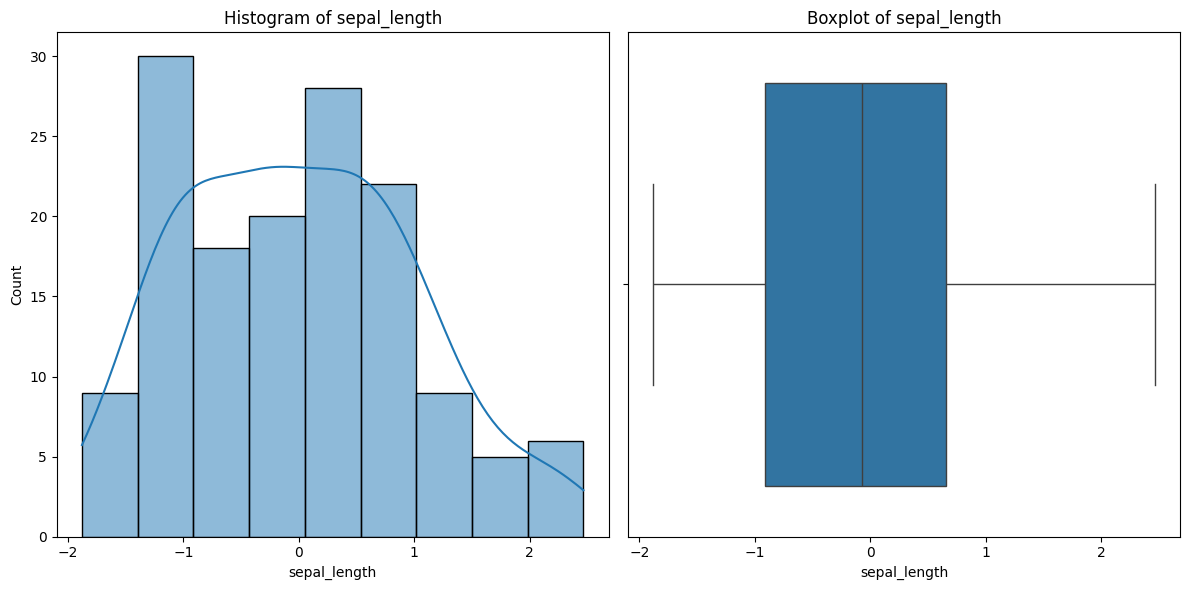

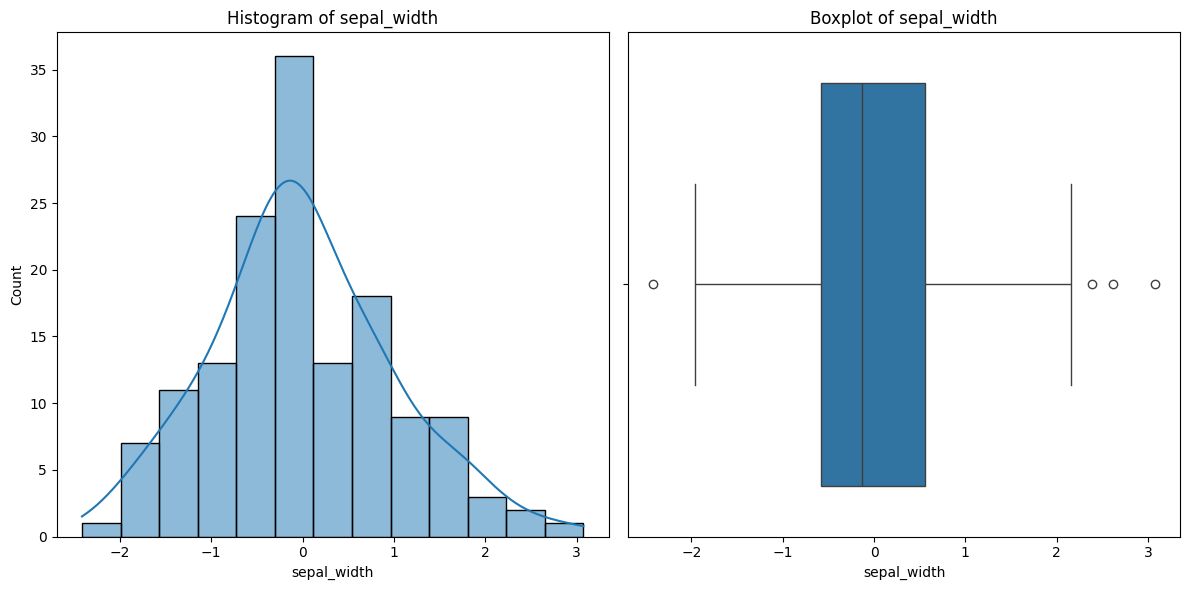

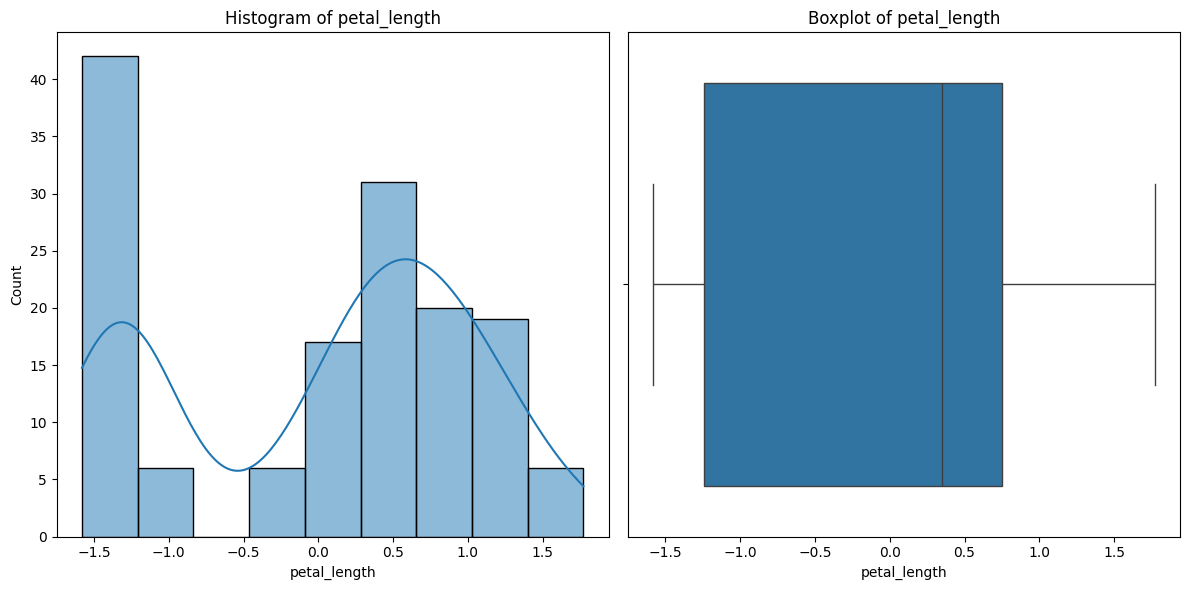

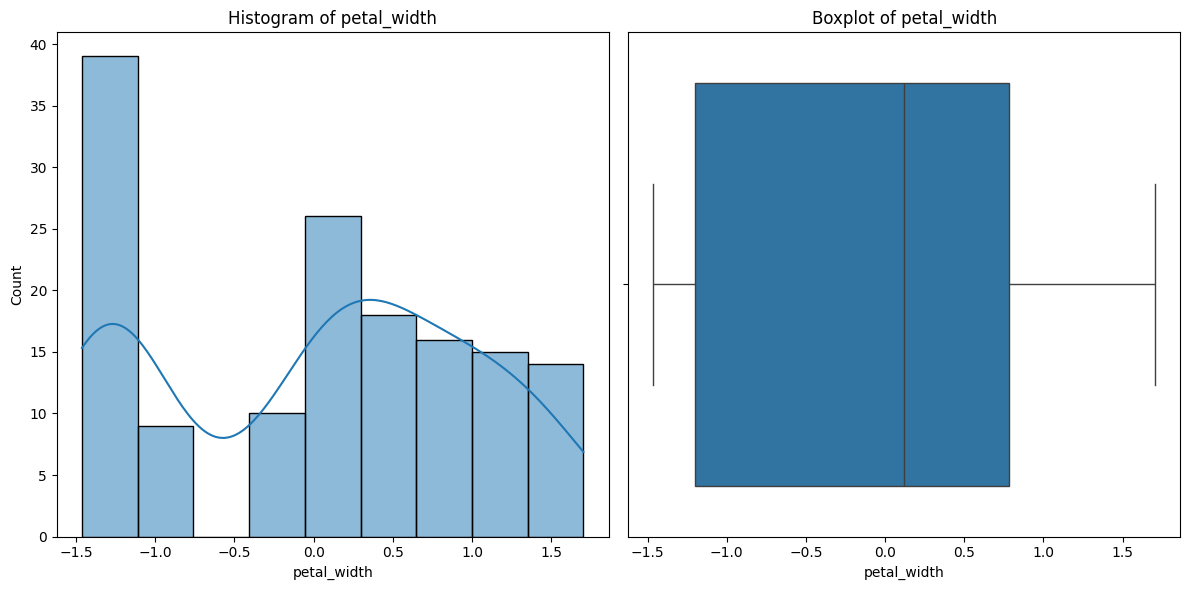

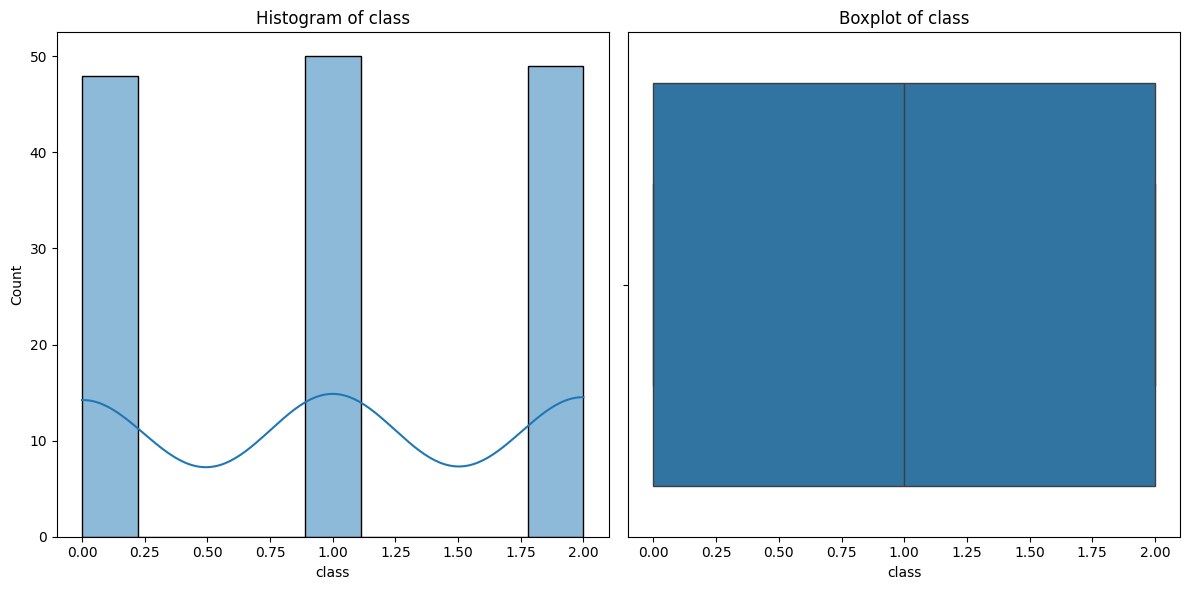

Accuracy: 0.2
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.00      0.00      0.00        10
         2.0       1.00      0.67      0.80         9

    accuracy                           0.20        30
   macro avg       0.33      0.22      0.27        30
weighted avg       0.30      0.20      0.24        30



In [15]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

master(url, column_names=column_names, problem_type='classification',model=model, params=params)

# Adult Income Dataset

The **Adult Income Dataset**, also known as the "Census Income" dataset, is a widely used dataset in machine learning for classification tasks². It was donated to the UCI Machine Learning Repository on April 30, 1996².

The dataset predicts whether income exceeds $50K per year based on census data². It has the following characteristics:
- **Multivariate** dataset²
- **48842 instances**²
- **14 features**²

The features include age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, and native-country².

Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information². You can access this dataset from the UCI Machine Learning Repository² or Kaggle¹.

Source: Conversation with Bing, 20/02/2024
(1) Adult - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Adult.
(2) Adult income dataset | Kaggle. https://www.kaggle.com/datasets/wenruliu/adult-income-dataset.
(3) Income Datasets - Census.gov. https://www.census.gov/topics/income-poverty/income/data/datasets.html.

5-Number Summary:
                  count  mean  std   min   25%   50%   75%   max
age            32537.00 -0.00 1.00 -1.58 -0.78 -0.12  0.69  3.77
workclass      32537.00  3.87 1.46  0.00  4.00  4.00  4.00  8.00
fnlwgt         32537.00 -0.00 1.00 -1.68 -0.68 -0.11  0.45 12.27
education      32537.00 10.30 3.87  0.00  9.00 11.00 12.00 15.00
education-num  32537.00  0.00 1.00 -3.53 -0.42 -0.03  0.75  2.30
marital-status 32537.00  2.61 1.51  0.00  2.00  2.00  4.00  6.00
occupation     32537.00  6.57 4.23  0.00  3.00  7.00 10.00 14.00
relationship   32537.00  1.45 1.61  0.00  0.00  1.00  3.00  5.00
race           32537.00  3.67 0.85  0.00  4.00  4.00  4.00  4.00
sex            32537.00  0.67 0.47  0.00  0.00  1.00  1.00  1.00
capital-gain   32537.00  0.00 1.00 -0.15 -0.15 -0.15 -0.15 13.39
capital-loss   32537.00  0.00 1.00 -0.22 -0.22 -0.22 -0.22 10.59
hours-per-week 32537.00 -0.00 1.00 -3.19 -0.04 -0.04  0.37  4.74
native-country 32537.00 36.72 7.82  0.00 39.00 39.00 39.00 41.00
income 

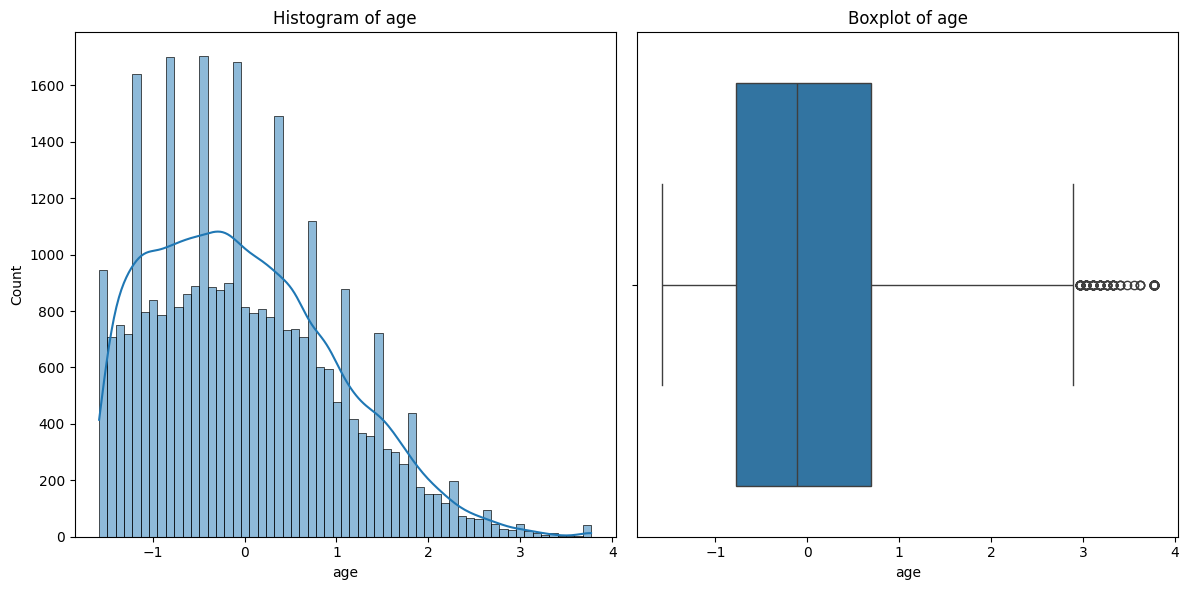

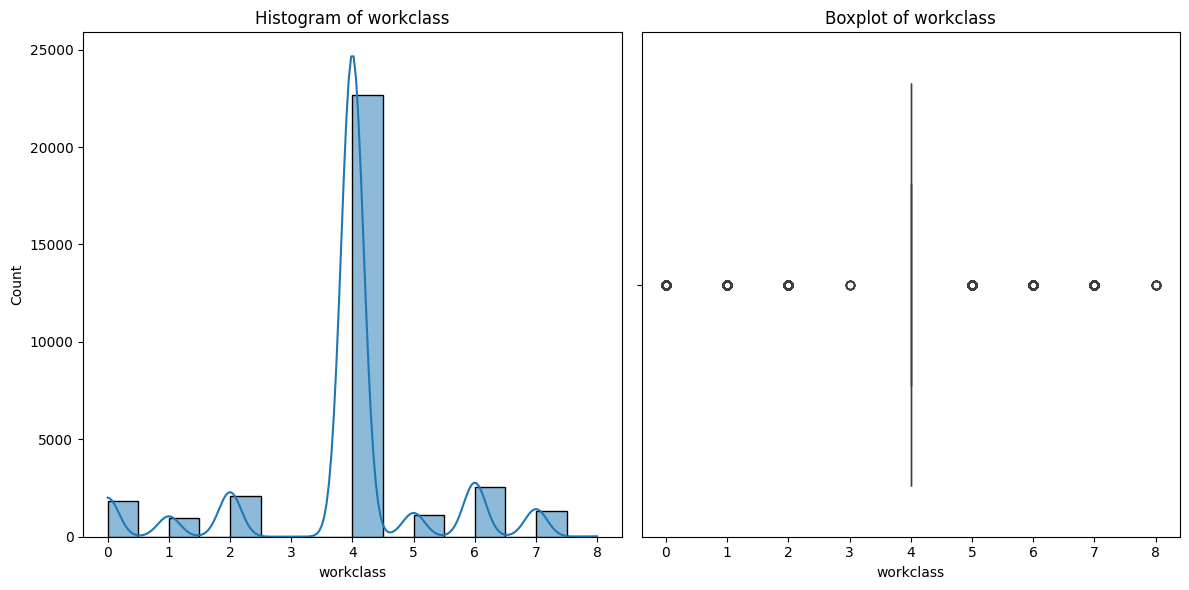

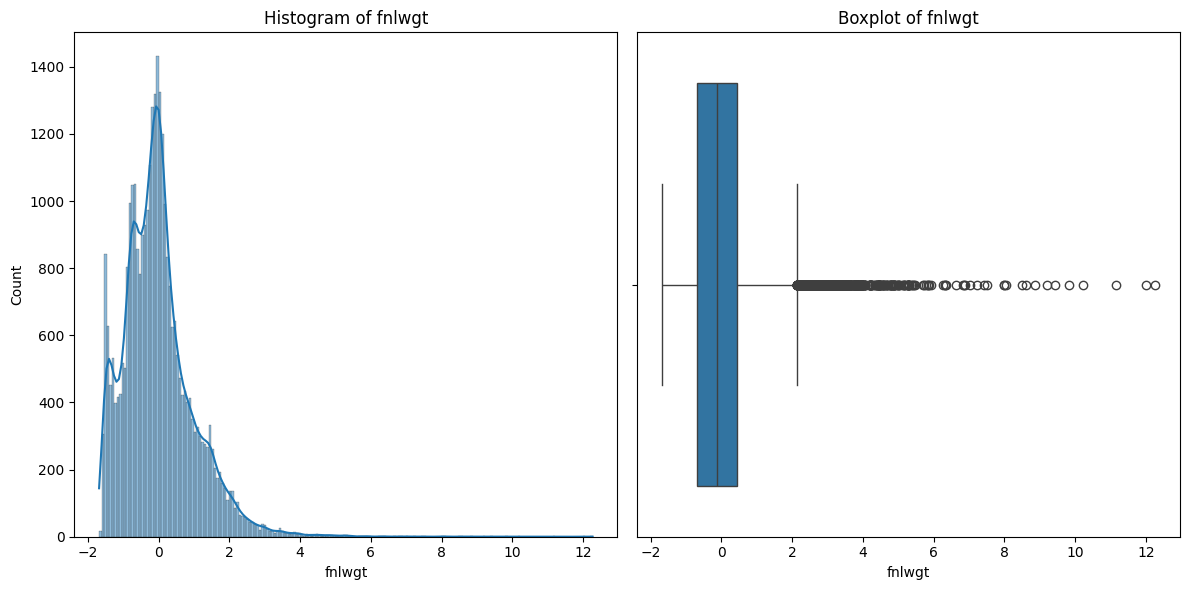

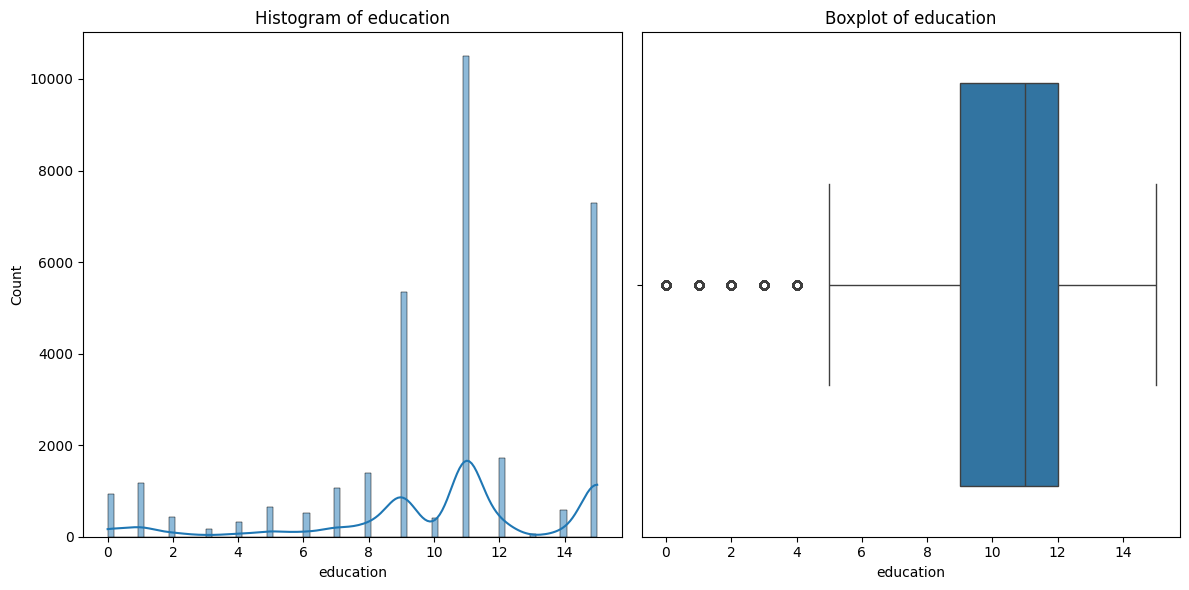

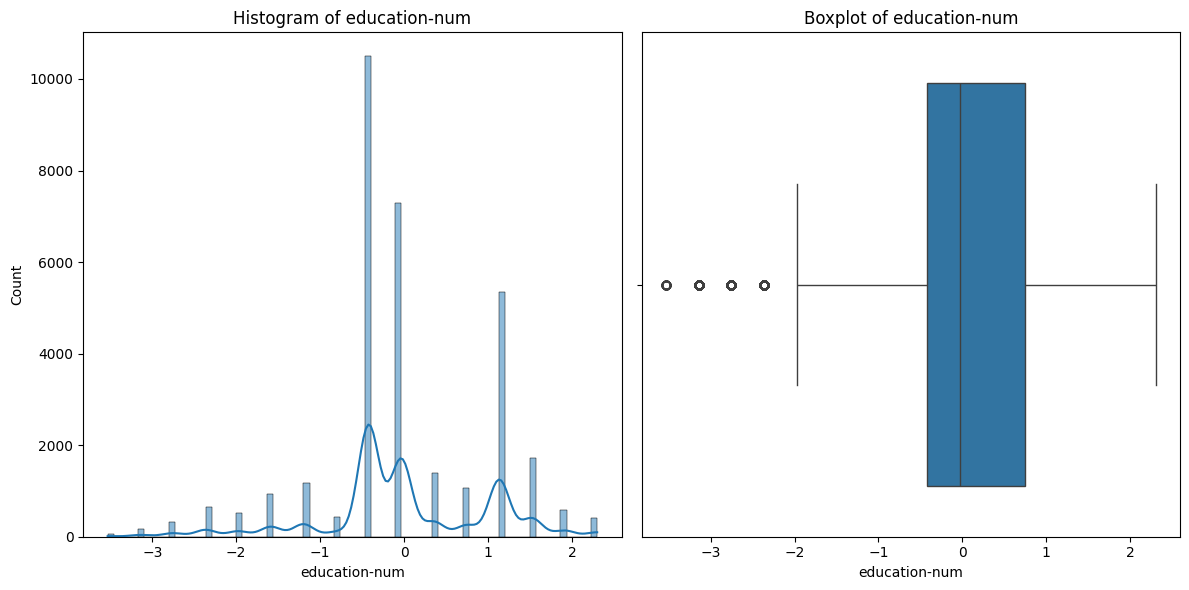

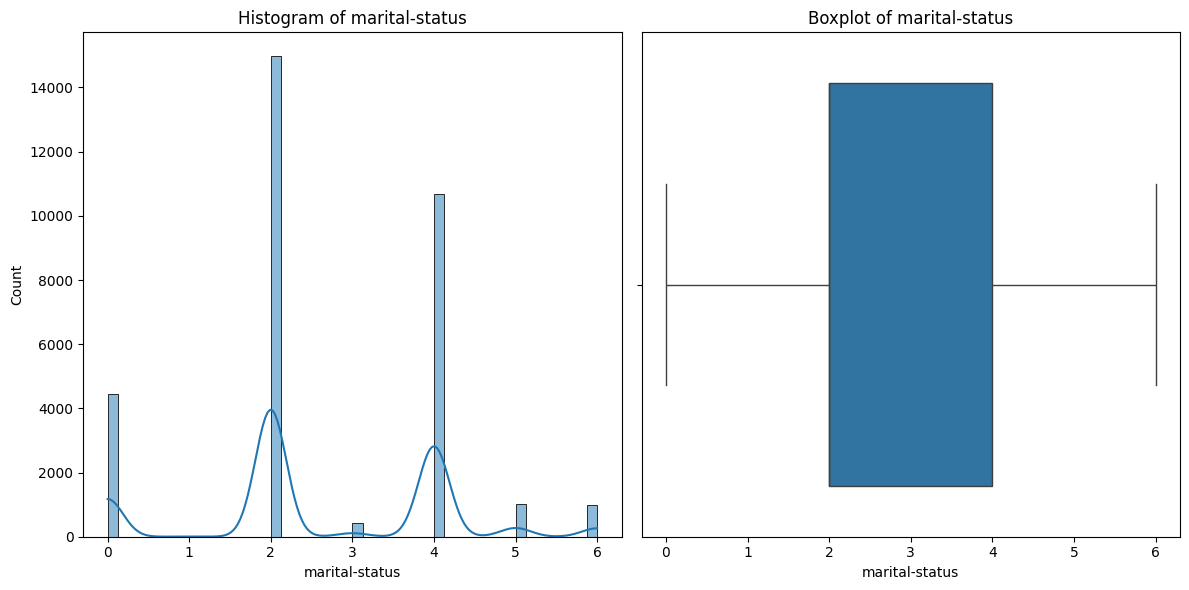

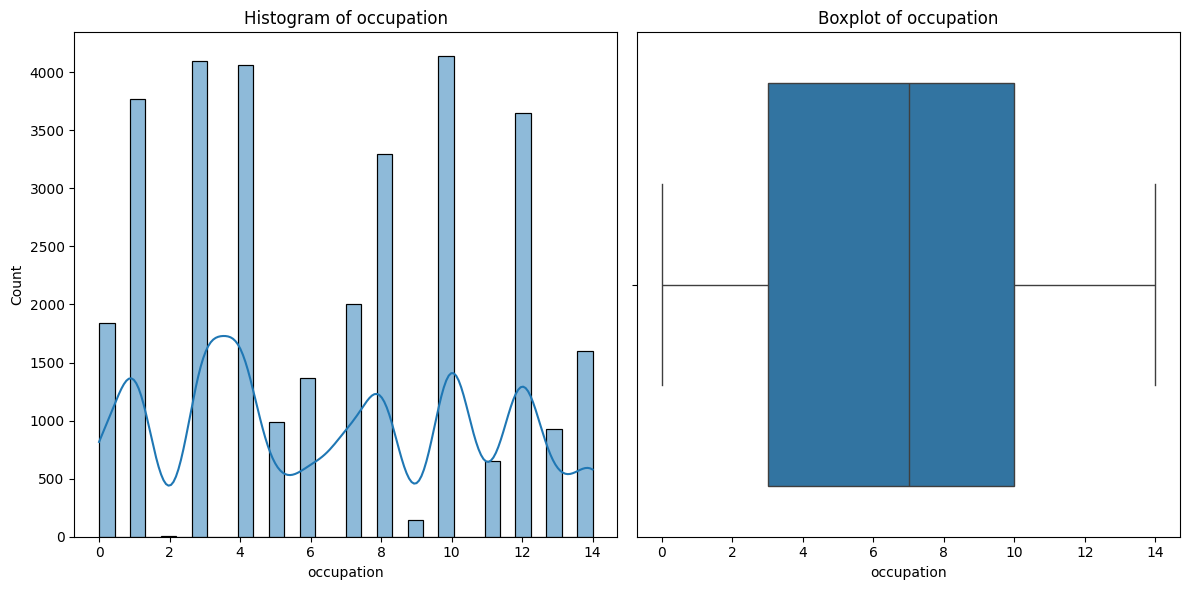

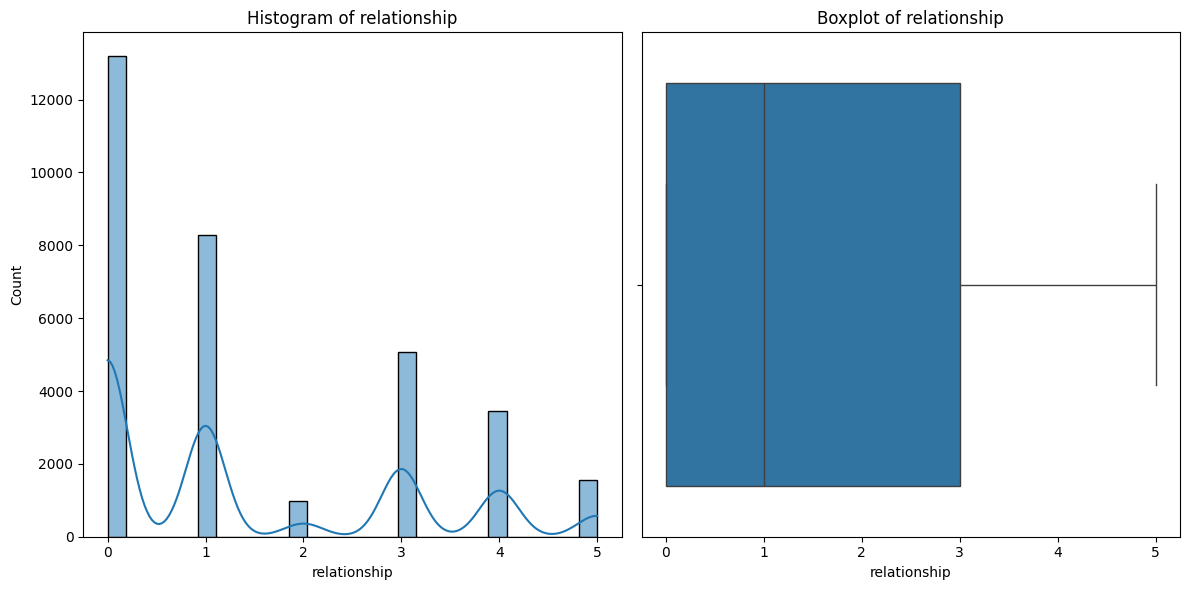

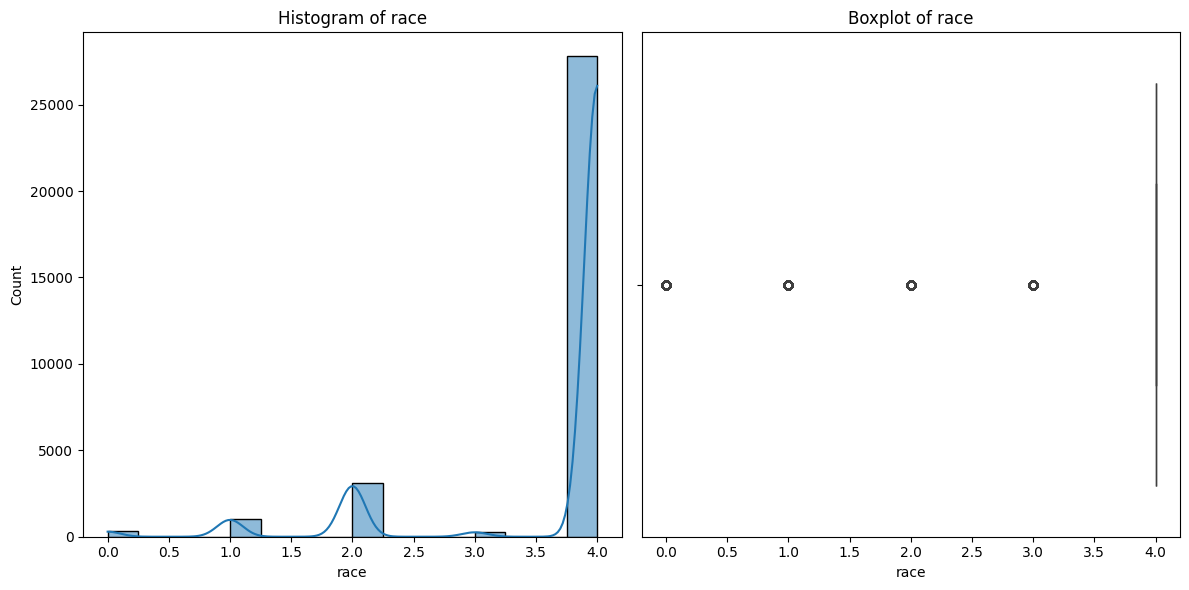

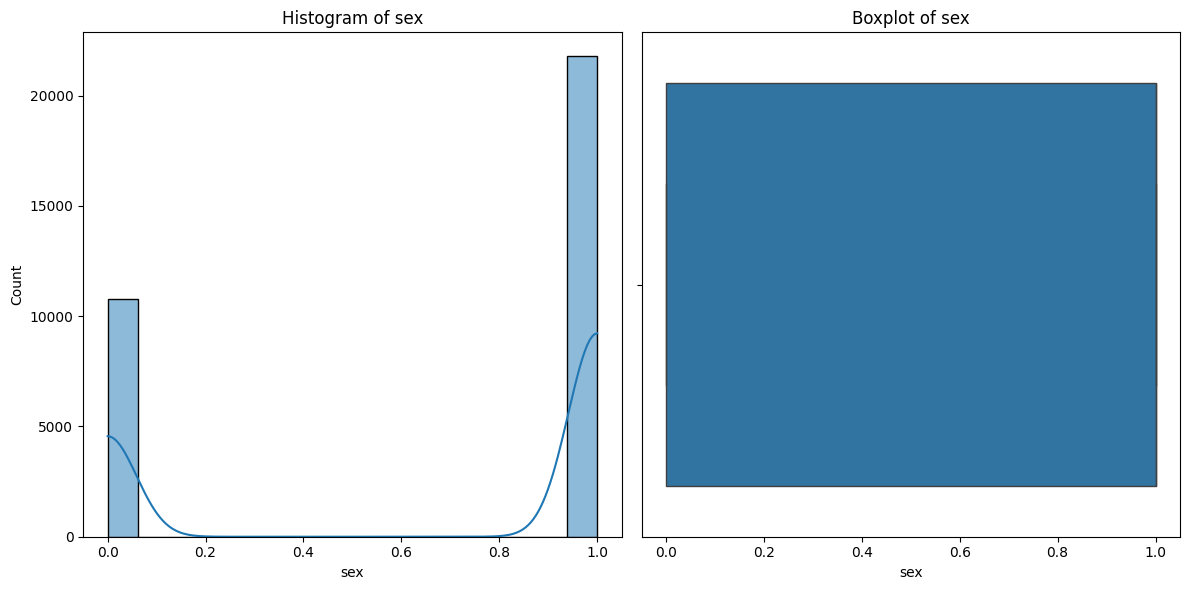

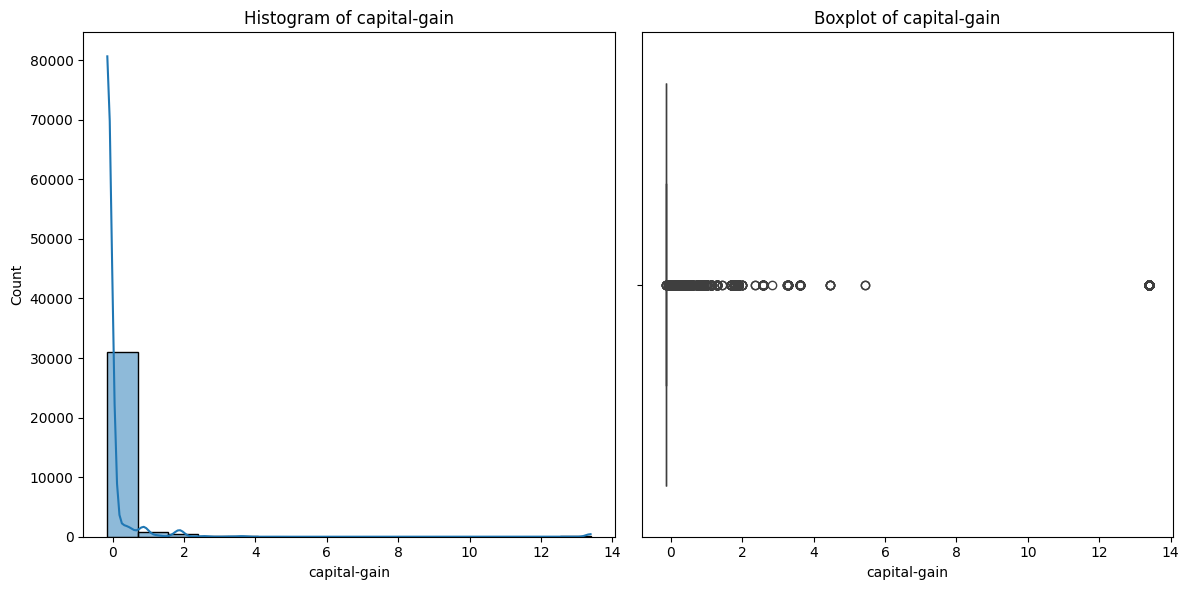

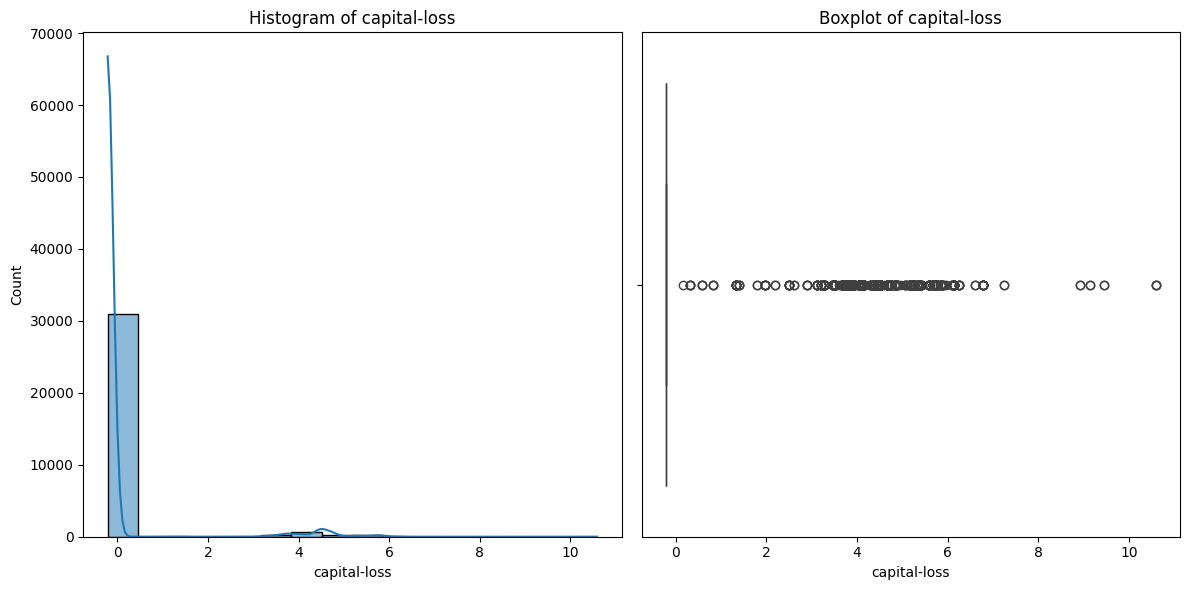

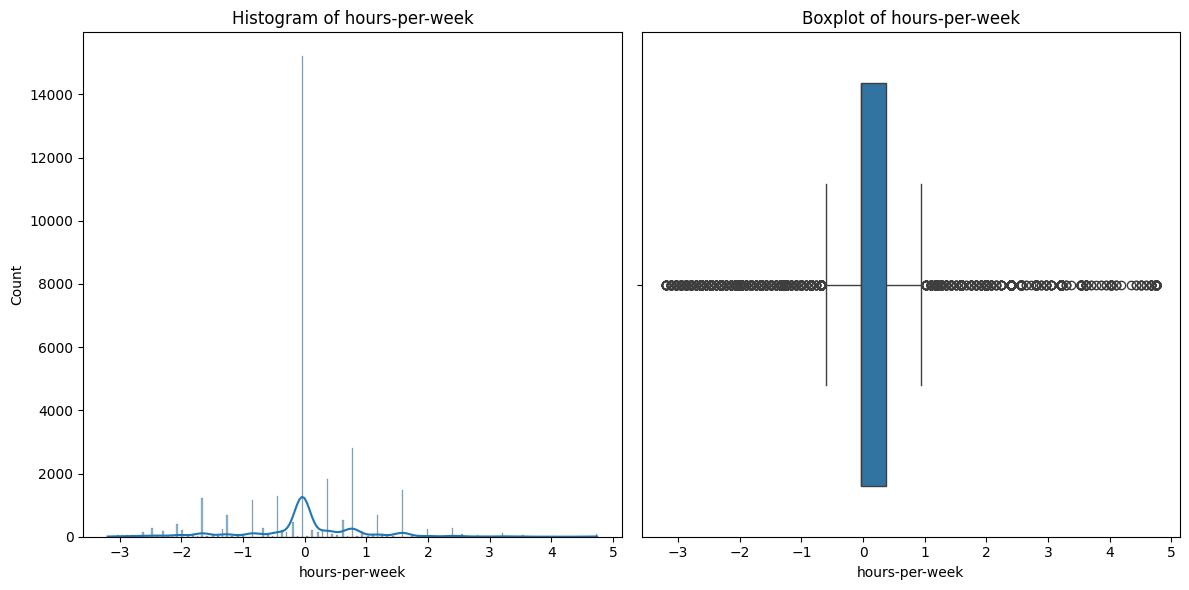

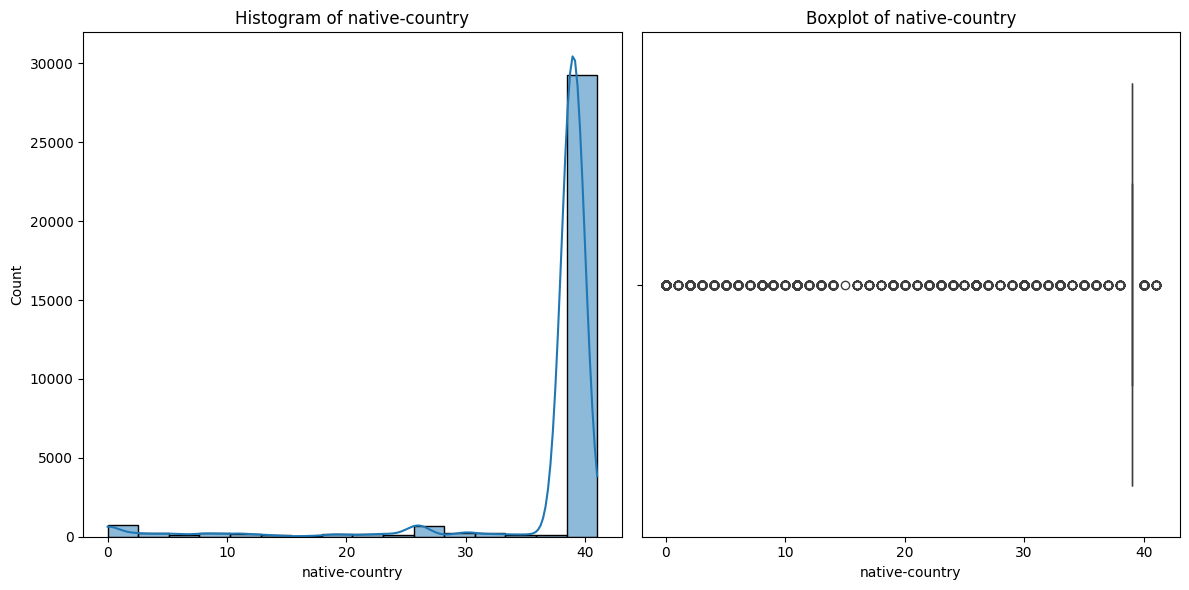

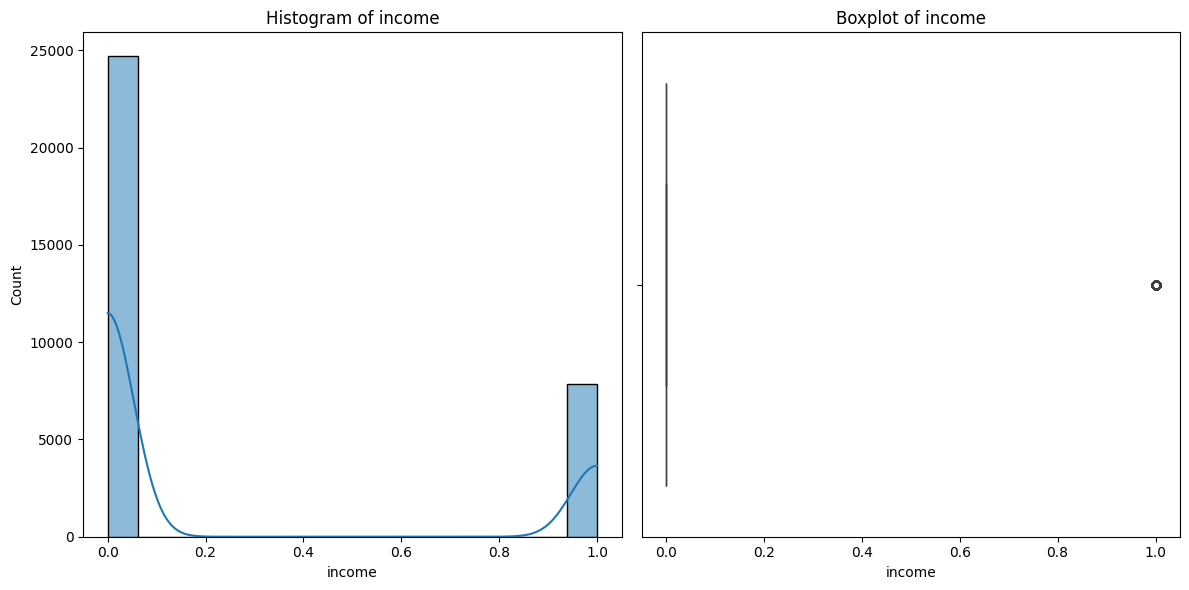

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [16]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income"
]

model = KMeans()
params = {'n_clusters':[2]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params)

# Heart Disease Dataset

The **Heart Disease Dataset** is a comprehensive collection of heart disease information that has been widely used in machine learning for classification tasks². It was donated to the UCI Machine Learning Repository on June 30, 1988².

Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository²
- **Subject Area**: Health and Medicine²
- **Associated Tasks**: Classification²
- **Feature Type**: Categorical, Integer, Real²
- **Instances**: 303²
- **Features**: 13²

The dataset contains 76 attributes, but all published experiments refer to using a subset of 14 of them². The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4².

The 14 commonly used attributes are²:

- Age
- Sex
- Chest pain type (cp)
- Resting blood pressure (trestbps)
- Serum cholesterol in mg/dl (chol)
- Fasting blood sugar > 120 mg/dl (fbs)
- Resting electrocardiographic results (restecg)
- Maximum heart rate achieved (thalach)
- Exercise induced angina (exang)
- ST depression induced by exercise relative to rest (oldpeak)
- The slope of the peak exercise ST segment (slope)
- Number of major vessels (0-3) colored by flourosopy (ca)
- Thal: 3 = normal; 6 = fixed defect; 7 = reversible defect (thal)
- Diagnosis of heart disease (angiographic disease status) (num)

Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information².

Source: Conversation with Bing, 20/02/2024
(1) Heart Disease - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease.
(2) Heart Disease Dataset | Kaggle. https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset.
(3) Cardiac Atlas Project – sharing a large-scale database of cardiac .... https://www.cardiacatlas.org/.
(4) Data | Centers for Disease Control and Prevention. https://data.cdc.gov/browse/select_dataset?tags=heart+disease.
(5) Heart Disease Dataset (Comprehensive) | IEEE DataPort. https://ieee-dataport.org/open-access/heart-disease-dataset-comprehensive.
(6) Bayesian network in Python using pgmpy - VTUPulse. https://vtupulse.com/machine-learning/bayesian-network-in-python-using-pgmpy/.
(7) Heart Disease Dataset UCI | Kaggle. https://www.kaggle.com/datasets/ketangangal/heart-disease-dataset-uci.
(8) UCI Heart Disease Analysis - GitHub. https://github.com/stat432/heart-analysis.
(9) Heart failure clinical records - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records.
(10) Statlog (Heart) - UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Statlog+%28Heart%29.
(11) Heart Disease - Classifications (Machine Learning) | Kaggle. https://www.kaggle.com/code/cdabakoglu/heart-disease-classifications-machine-learning.
(12) Heart Disease Classification | Kaggle. https://www.kaggle.com/code/microvision/heart-disease-classification.
(13) An Extensive Dataset for the Heart Disease Classification System. https://data.mendeley.com/datasets/65gxgy2nmg/2.

5-Number Summary:
          count   mean   std    min    25%    50%    75%    max
age      303.00  54.44  9.04  29.00  48.00  56.00  61.00  77.00
sex      303.00   0.68  0.47   0.00   0.00   1.00   1.00   1.00
cp       303.00   3.16  0.96   1.00   3.00   3.00   4.00   4.00
trestbps 303.00 131.69 17.60  94.00 120.00 130.00 140.00 200.00
chol     303.00 246.69 51.78 126.00 211.00 241.00 275.00 564.00
fbs      303.00   0.15  0.36   0.00   0.00   0.00   0.00   1.00
restecg  303.00   0.99  0.99   0.00   0.00   1.00   2.00   2.00
thalach  303.00 149.61 22.88  71.00 133.50 153.00 166.00 202.00
exang    303.00   0.33  0.47   0.00   0.00   0.00   1.00   1.00
oldpeak  303.00   1.04  1.16   0.00   0.00   0.80   1.60   6.20
slope    303.00   1.60  0.62   1.00   1.00   2.00   2.00   3.00
num      303.00   0.94  1.23   0.00   0.00   0.00   2.00   4.00


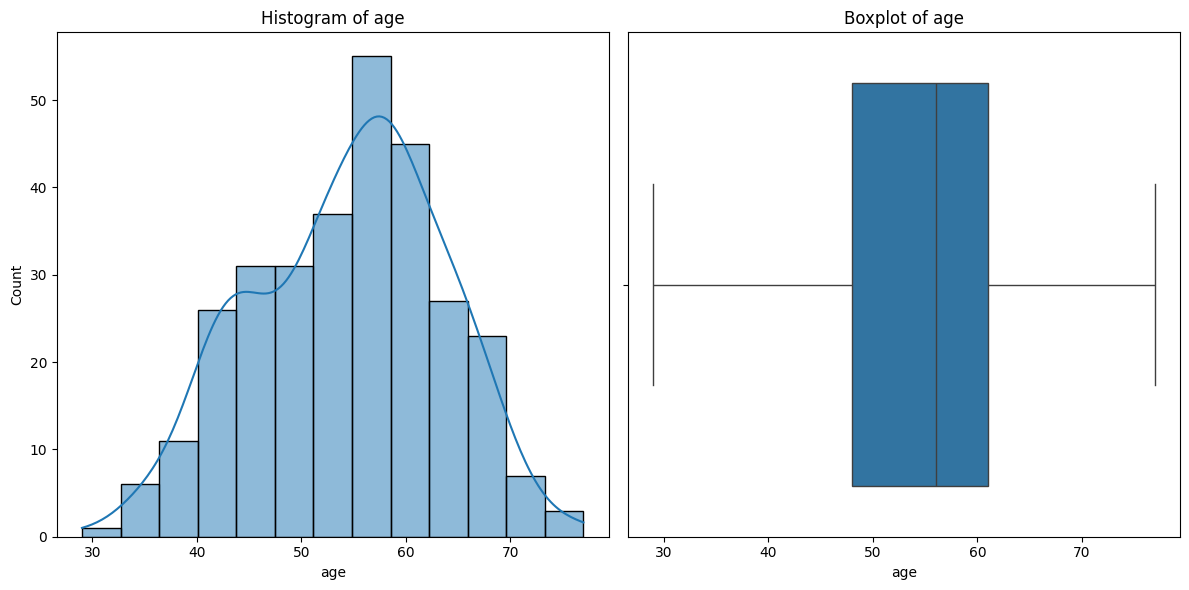

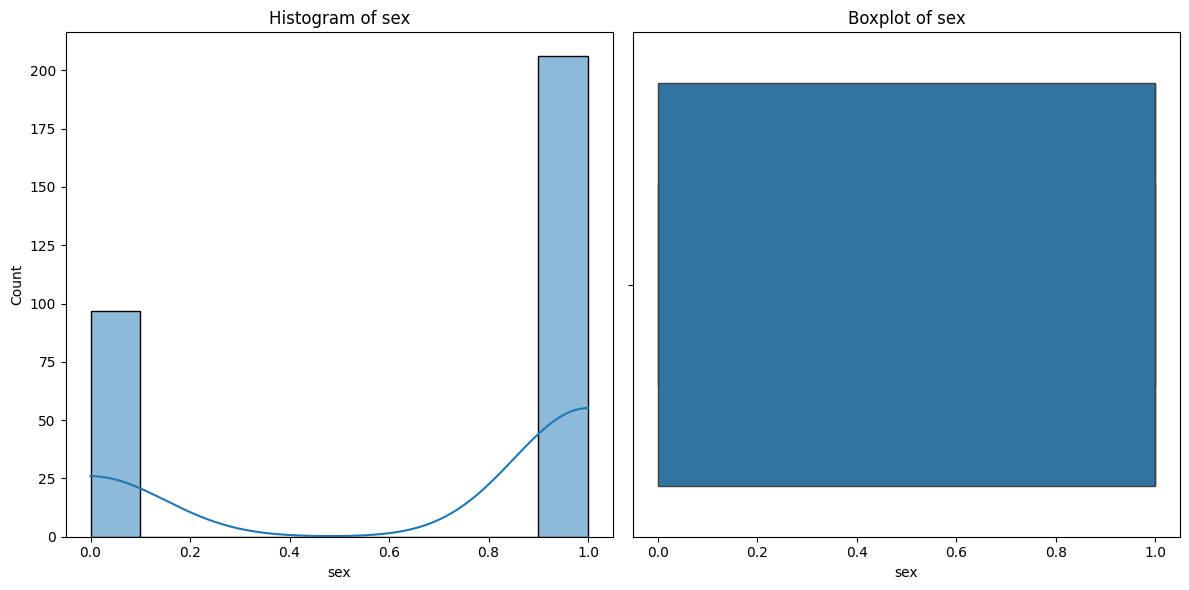

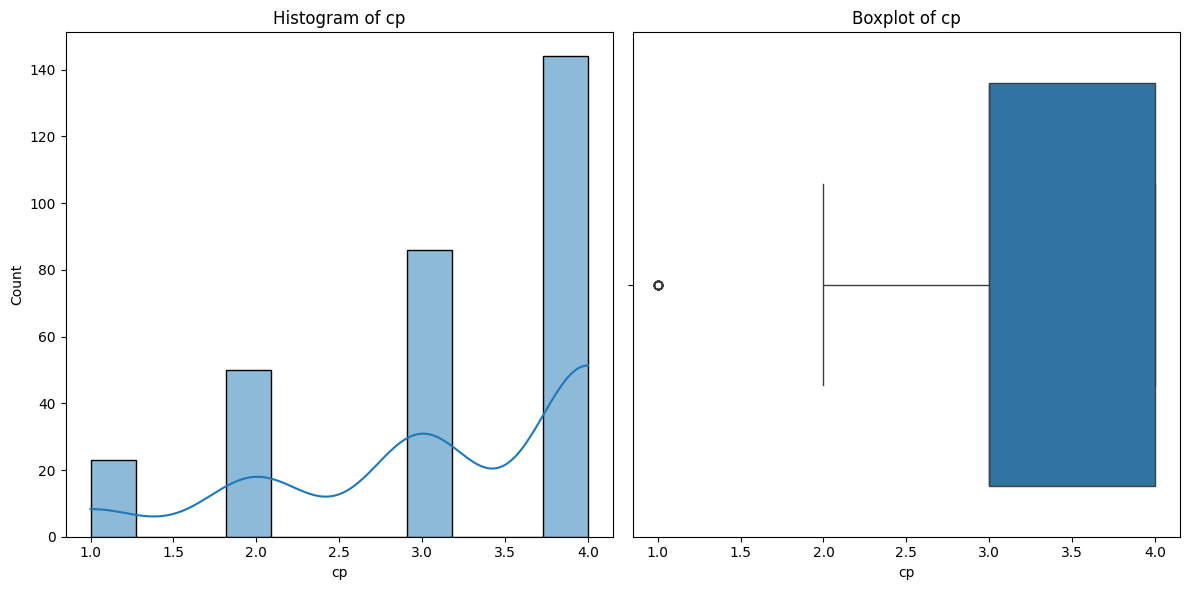

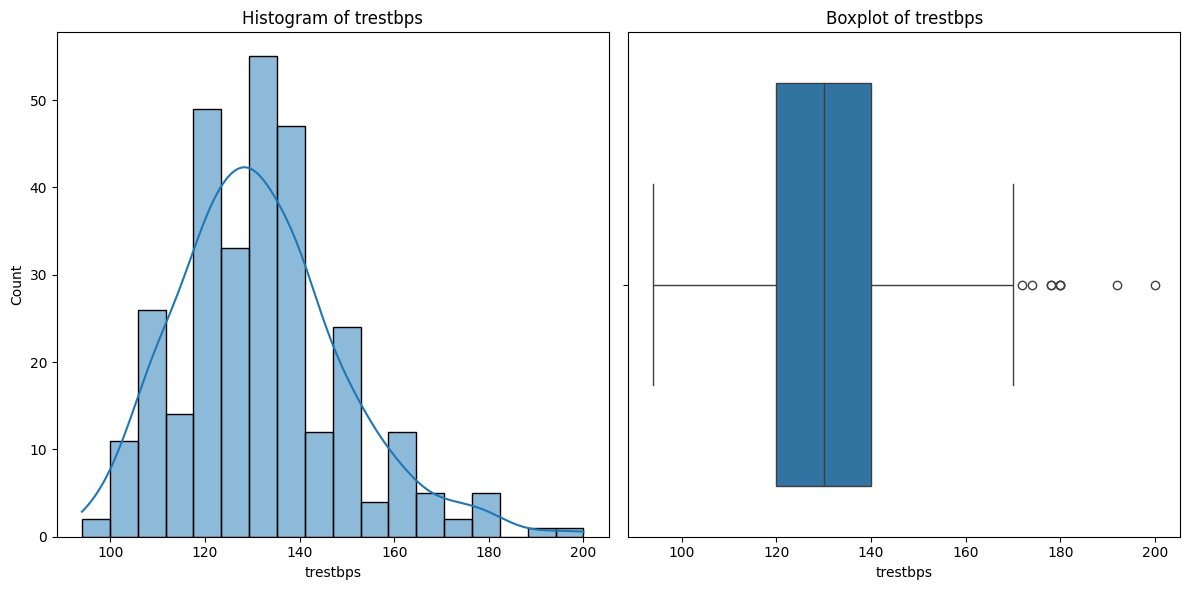

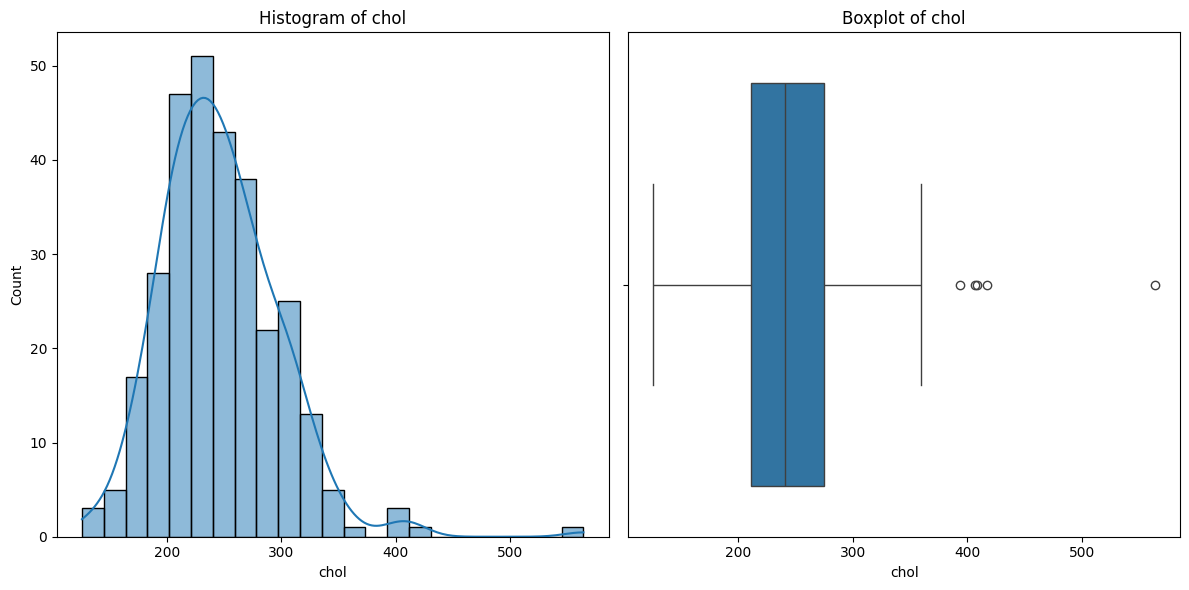

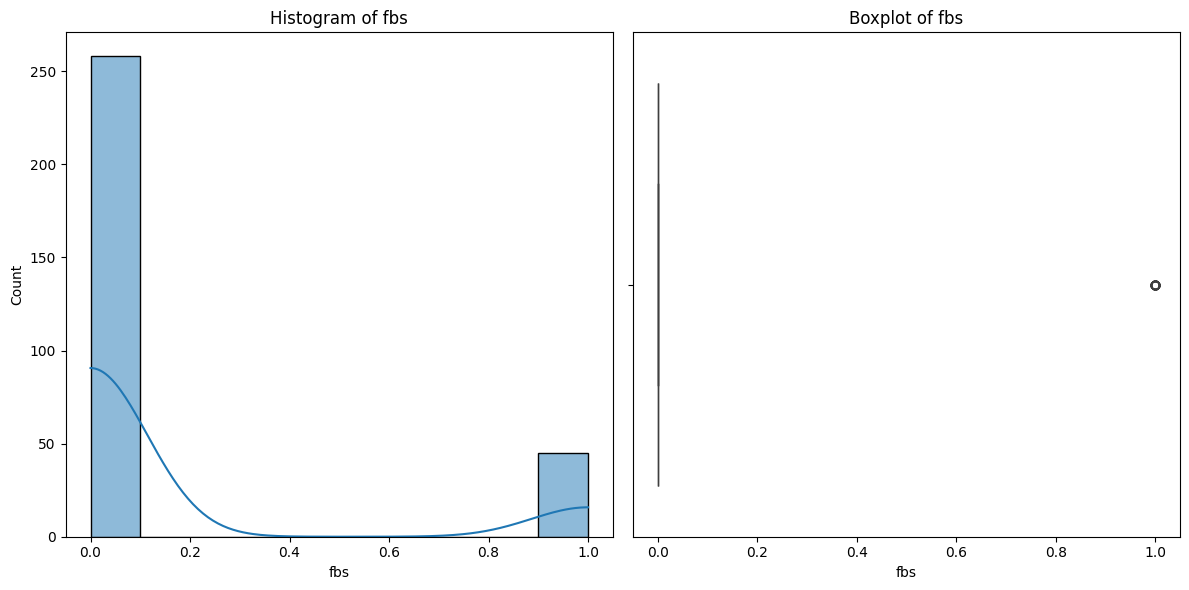

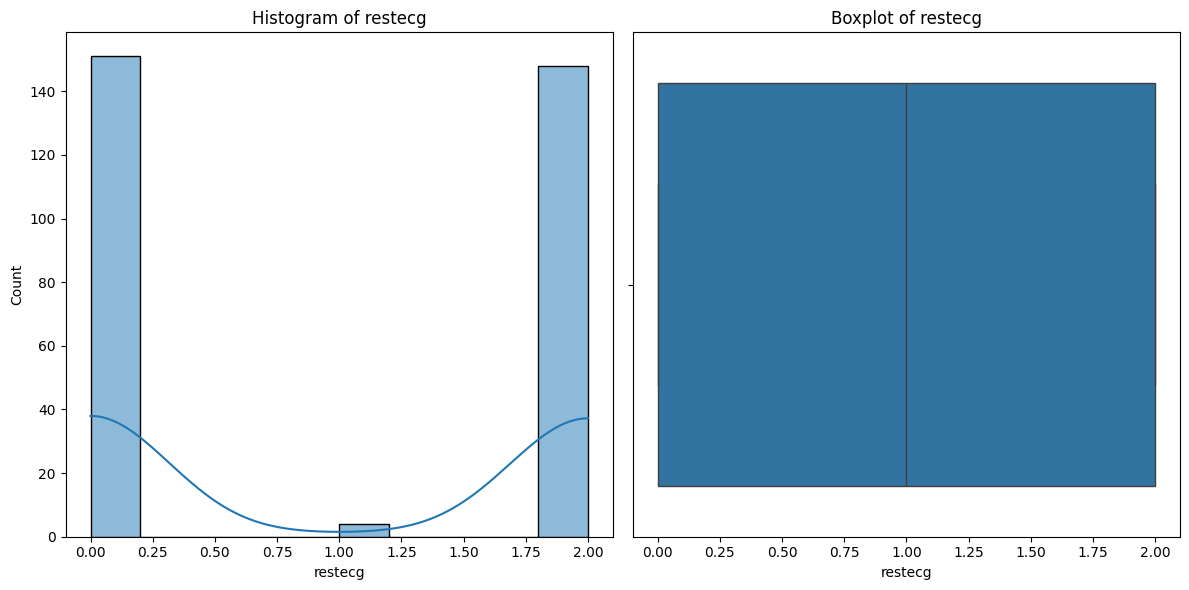

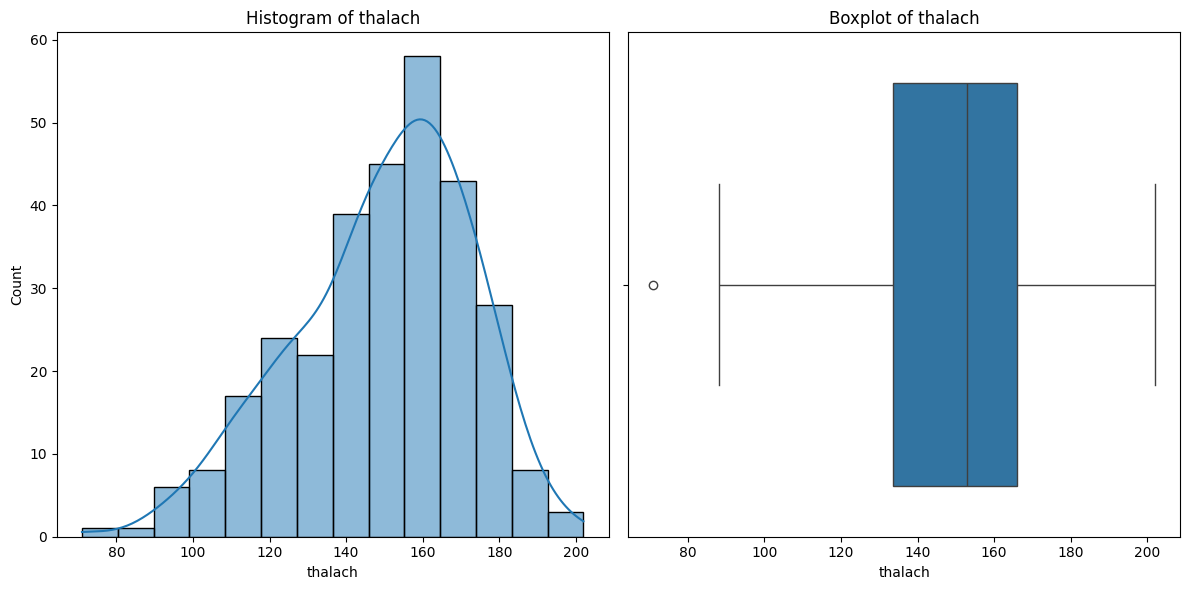

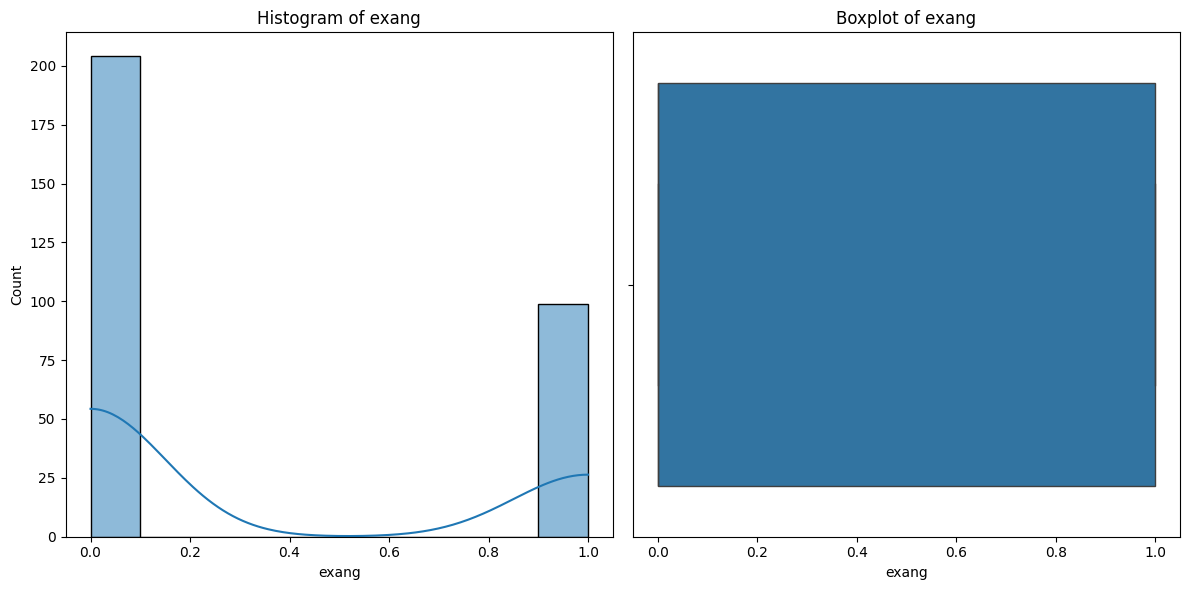

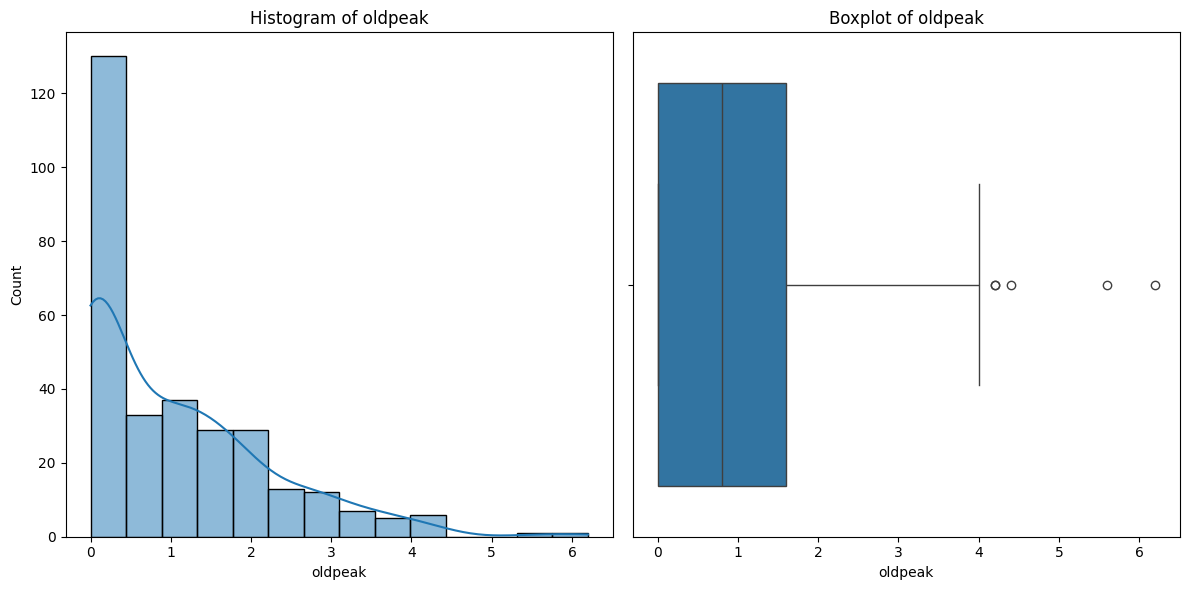

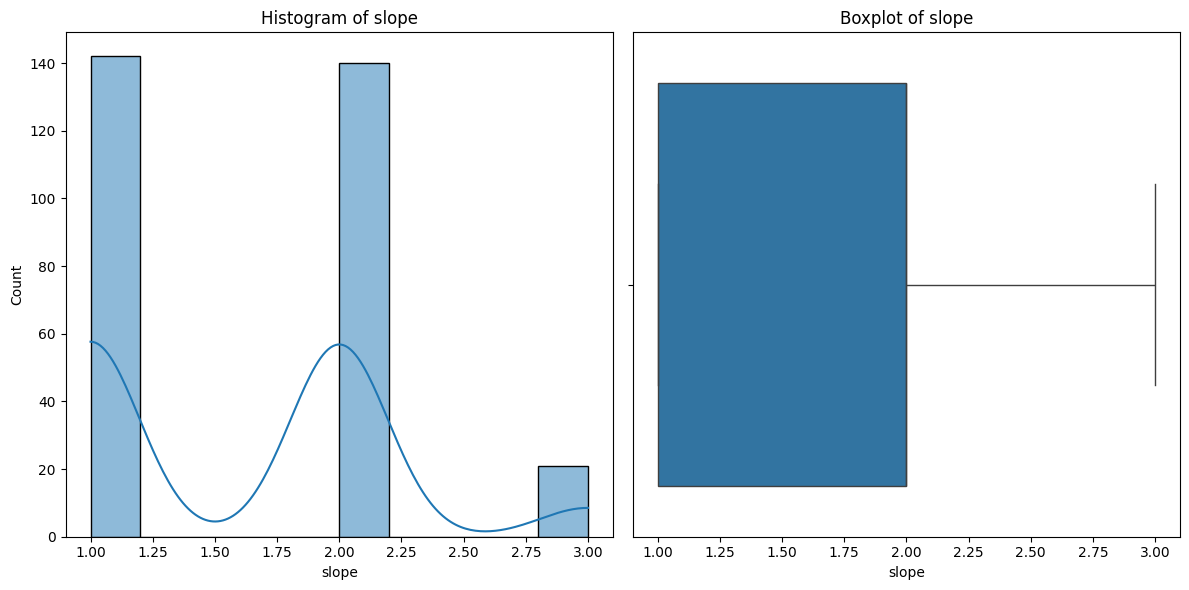

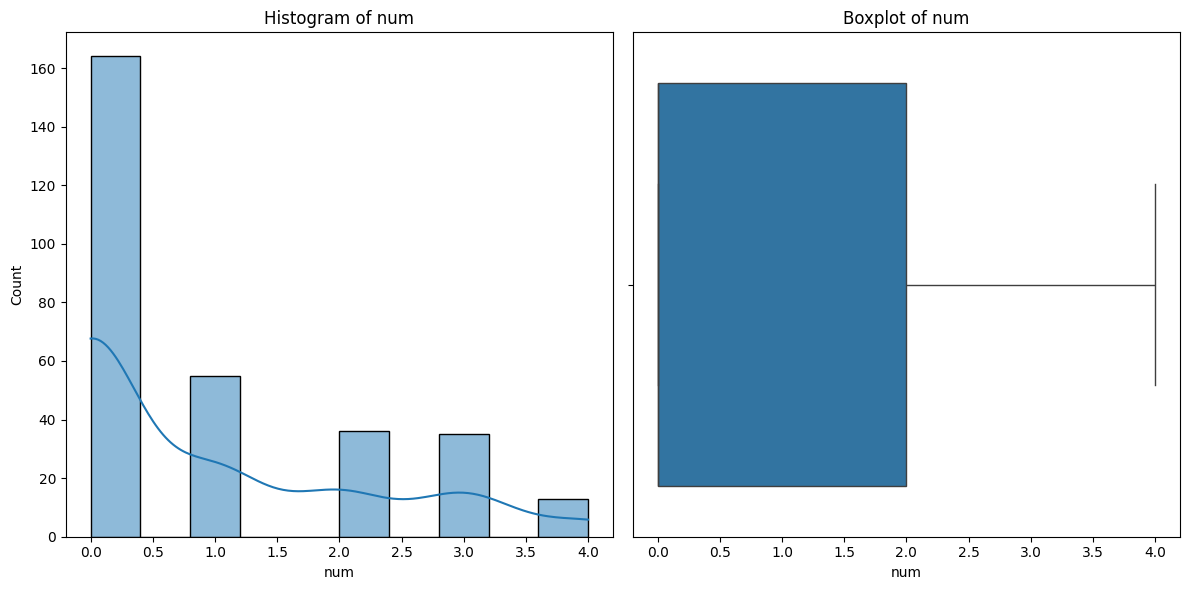

Accuracy: 0.5245901639344263
              precision    recall  f1-score   support

         0.0       0.78      0.86      0.82        29
         1.0       0.24      0.58      0.34        12
         2.0       0.00      0.00      0.00         9
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         4

    accuracy                           0.52        61
   macro avg       0.20      0.29      0.23        61
weighted avg       0.42      0.52      0.46        61



In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope",
    "ca",
    "thal",
    "num"
]

model = KMeans()
params = {'n_clusters':[2]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params)

# Wine Dataset

The **Wine Dataset** from the UCI Machine Learning Repository is another good choice for K-means clustering¹. This dataset is the result of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars¹.

Here are some details about this dataset:

- **Dataset Source**: UCI Machine Learning Repository¹
- **Subject Area**: Chemistry¹
- **Associated Tasks**: Classification, Clustering¹
- **Feature Type**: Real¹
- **Instances**: 178¹
- **Features**: 13¹
- **Classes**: 3¹

The features include Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, and Proline¹.

Please note that the actual number of instances and features may vary depending on the specific version of the dataset you are using. Always check the dataset documentation for the most accurate information¹.

Source: Conversation with Bing, 20/02/2024
(1) k-means, k-mediods clustering on UCI seed dataset | Kaggle. https://www.kaggle.com/code/praanj/k-means-k-mediods-clustering-on-uci-seed-dataset.
(2) UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/seeds.
(3) UCI Adult Dataset Exploratory Data Analysis - GitHub. https://github.com/rabjotsinghsidhar/UCI-Adult-Dataset-Exploratory-Data-Analysis.
(4) UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Yeast.
(5) vasuprada/K-MEANS-CLUSTERING - GitHub. https://github.com/vasuprada/K-MEANS-CLUSTERING.
(6) quanghoan/kmeans-and-spectral-clustering-image-segmentaion. https://github.com/quanghoan/kmeans-and-spectral-clustering-image-segmentaion.
(7) UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/837/product+classification+and+clustering.

5-Number Summary:
                              count   mean    std    min    25%    50%    75%  \
Alcohol                      178.00  13.00   0.81  11.03  12.36  13.05  13.68   
Malic acid                   178.00   2.34   1.12   0.74   1.60   1.87   3.08   
Ash                          178.00   2.37   0.27   1.36   2.21   2.36   2.56   
Alcalinity of ash            178.00  19.49   3.34  10.60  17.20  19.50  21.50   
Magnesium                    178.00  99.74  14.28  70.00  88.00  98.00 107.00   
Total phenols                178.00   2.30   0.63   0.98   1.74   2.35   2.80   
Flavanoids                   178.00   2.03   1.00   0.34   1.21   2.13   2.88   
Nonflavanoid phenols         178.00   0.36   0.12   0.13   0.27   0.34   0.44   
Proanthocyanins              178.00   1.59   0.57   0.41   1.25   1.56   1.95   
Color intensity              178.00   5.06   2.32   1.28   3.22   4.69   6.20   
Hue                          178.00   0.96   0.23   0.48   0.78   0.96   1.12   
OD280/OD31

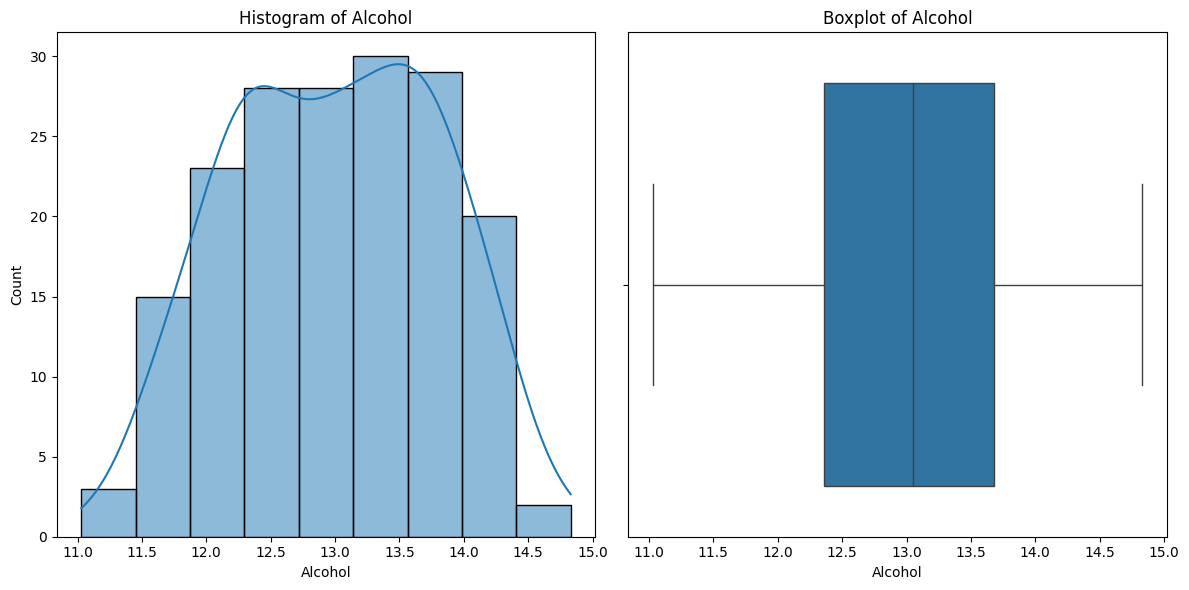

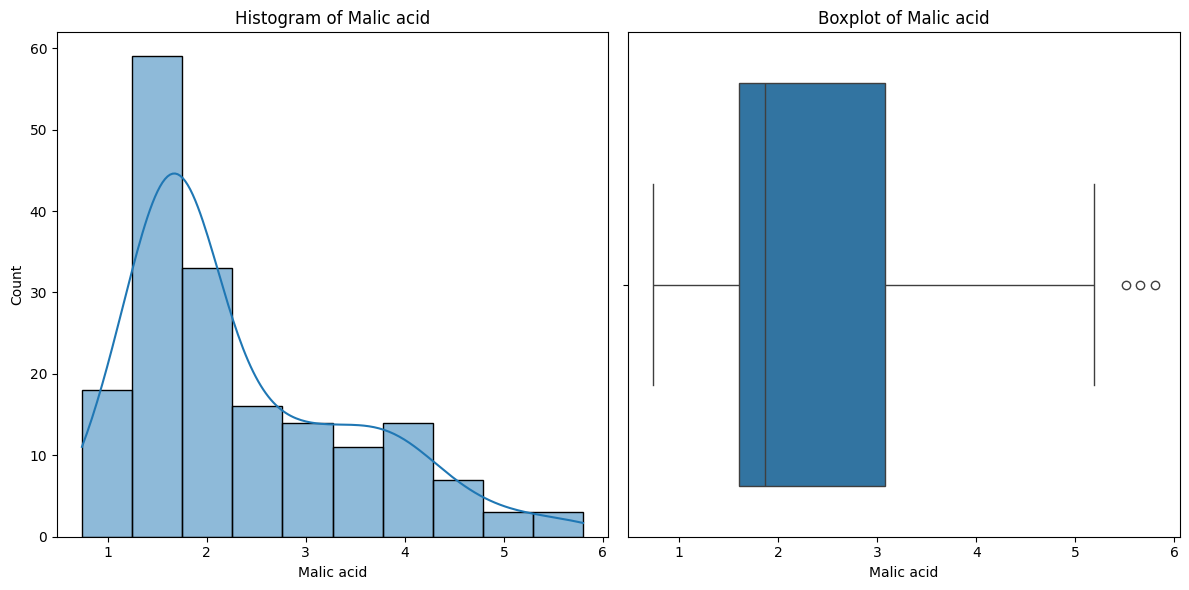

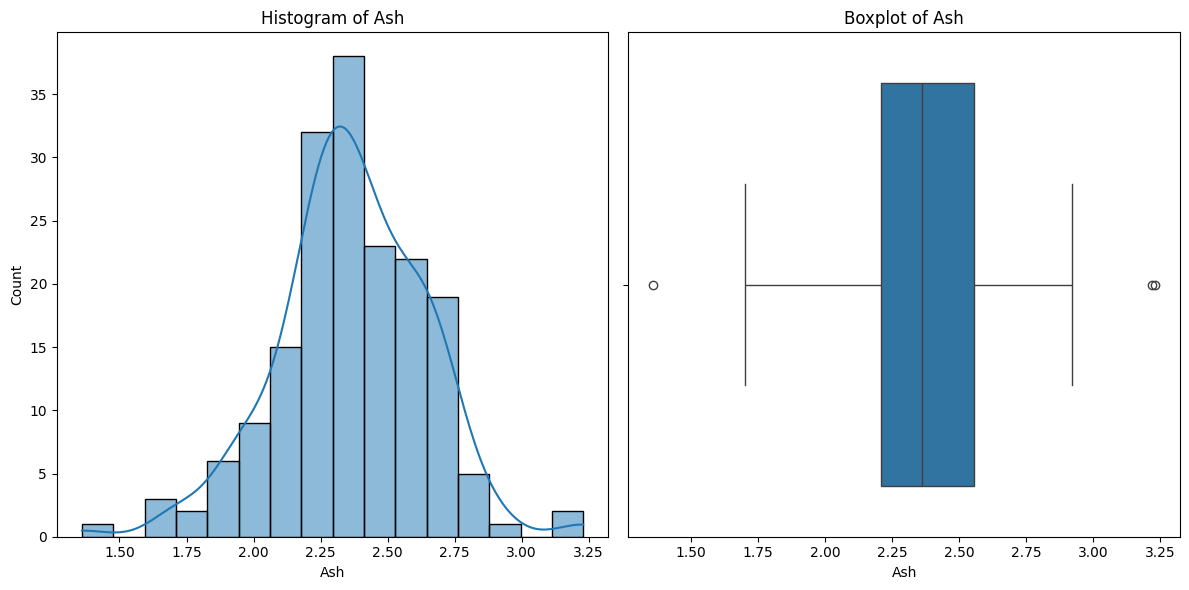

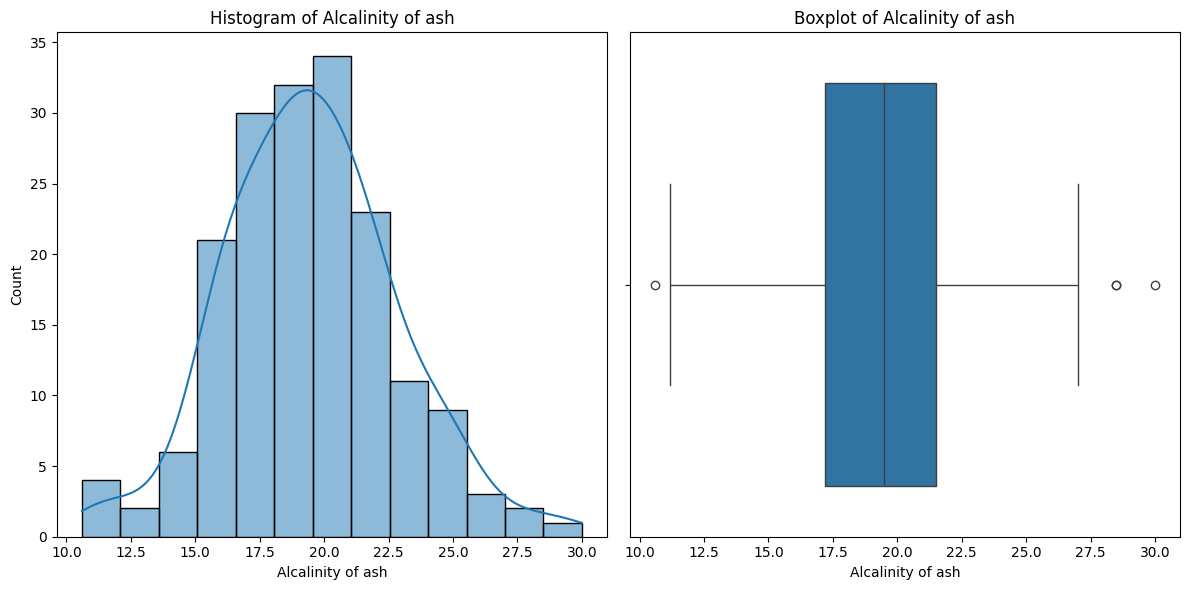

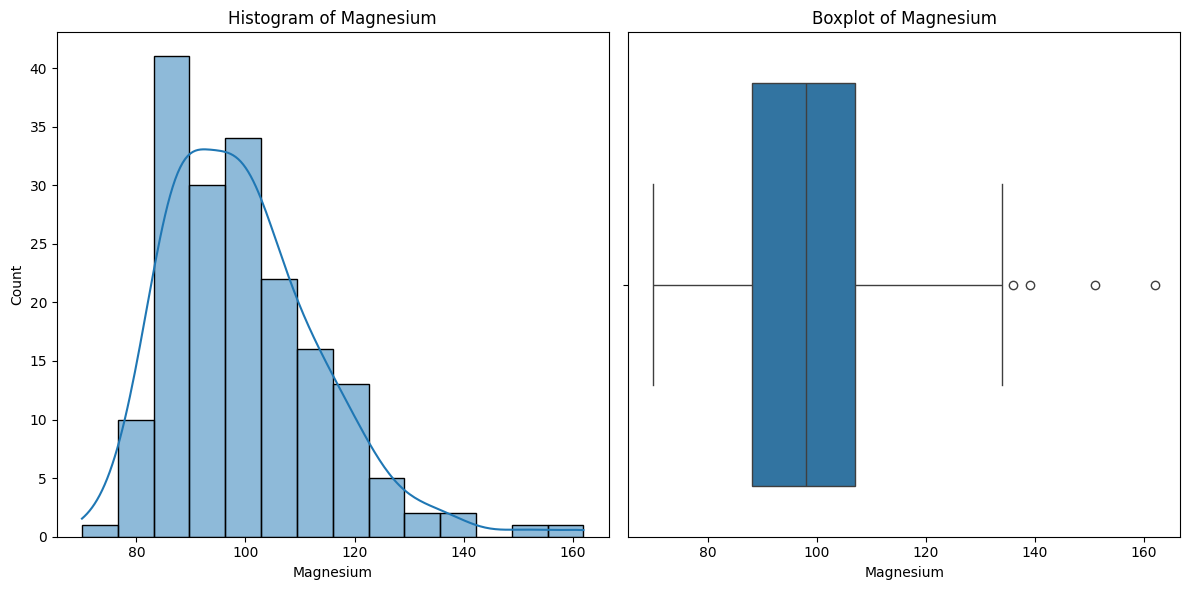

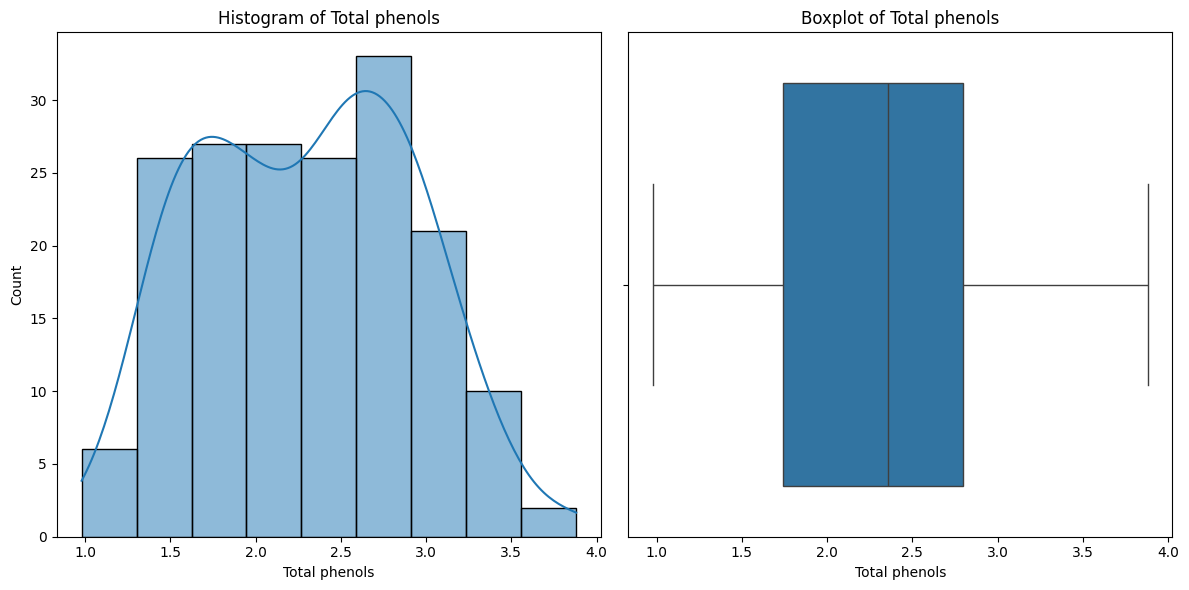

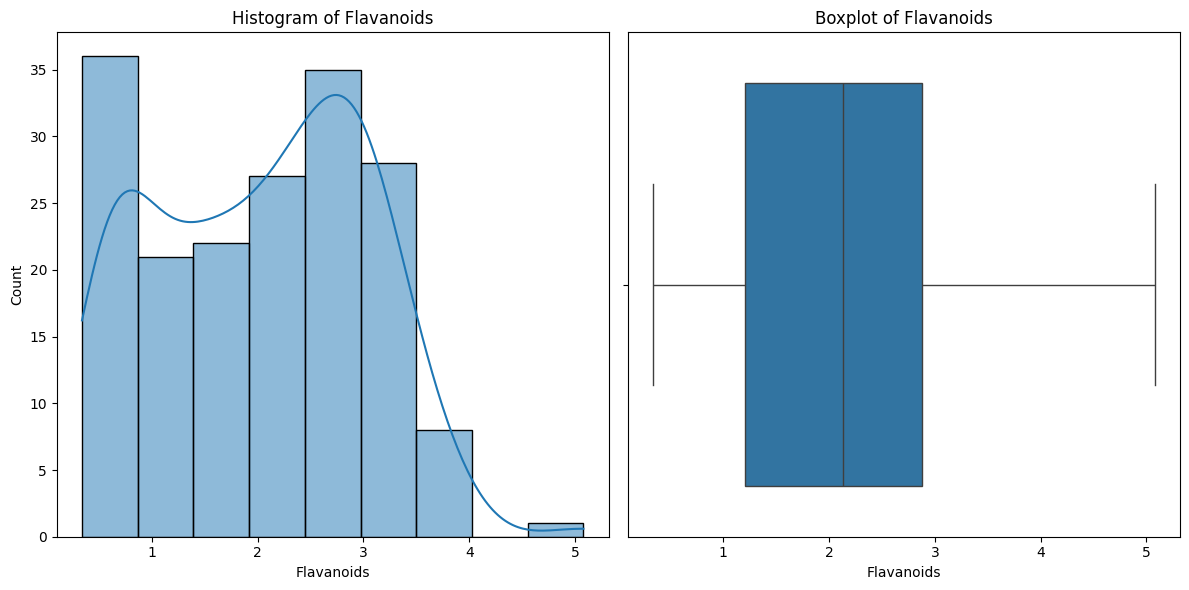

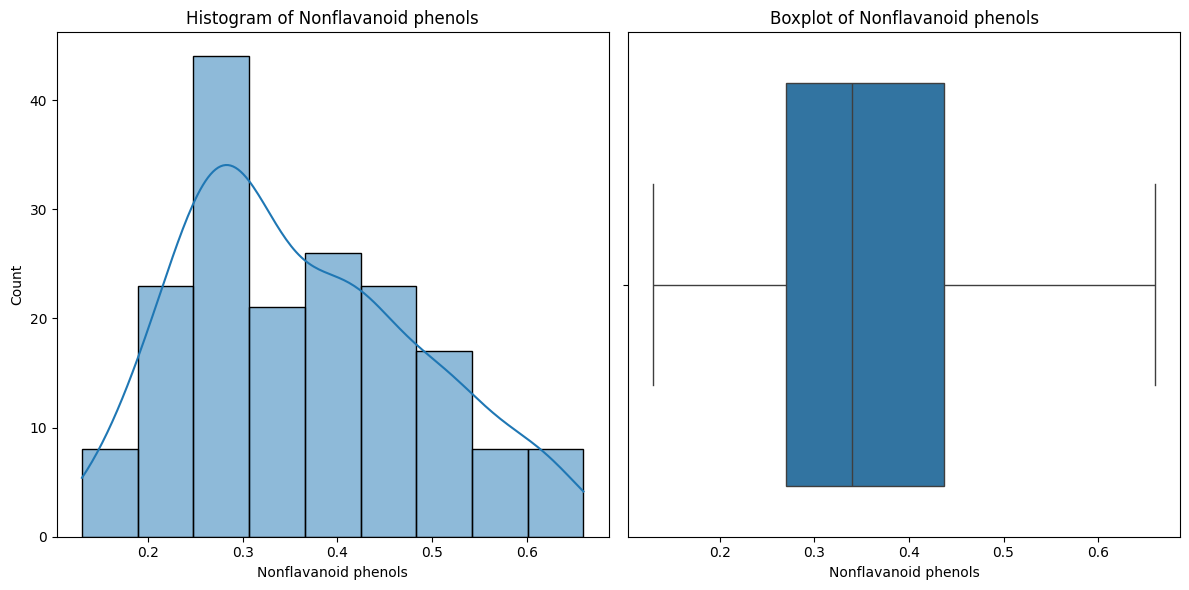

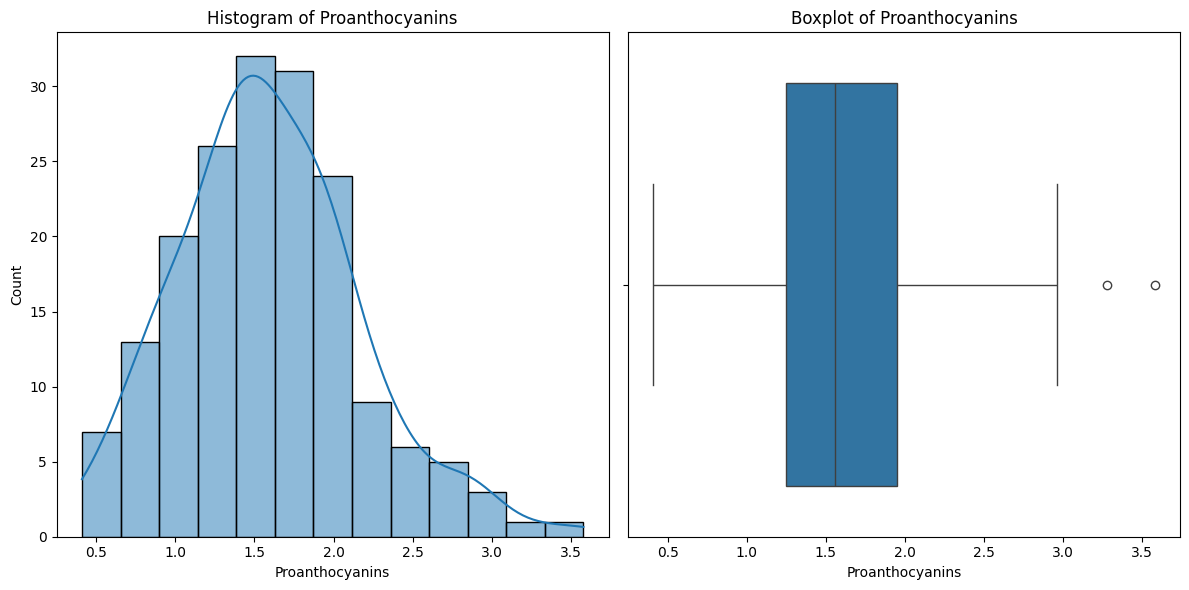

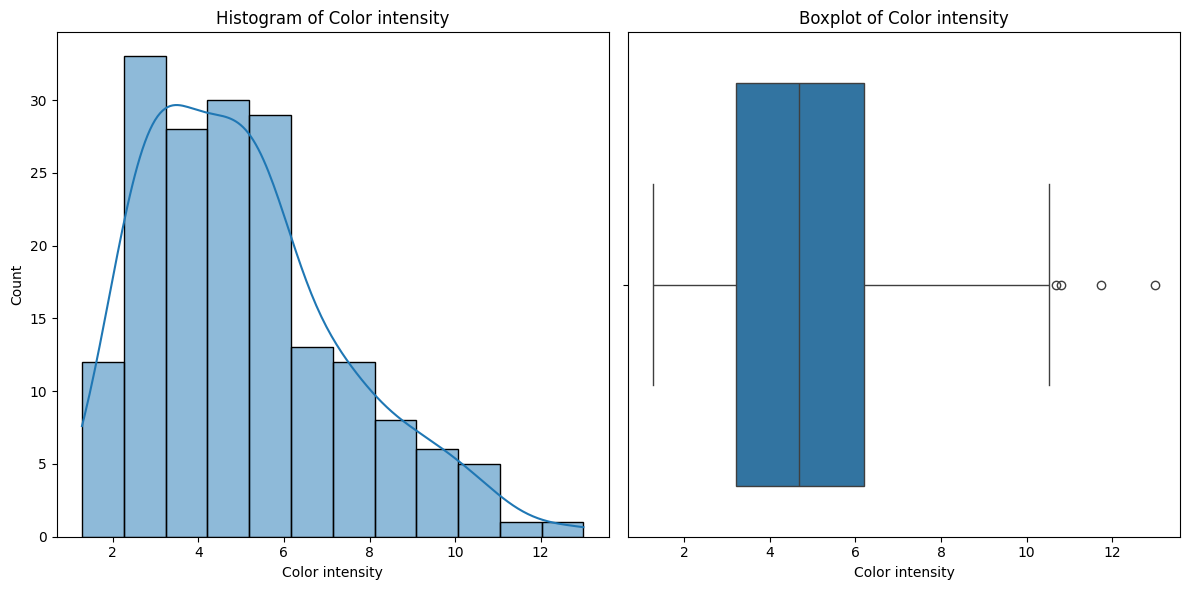

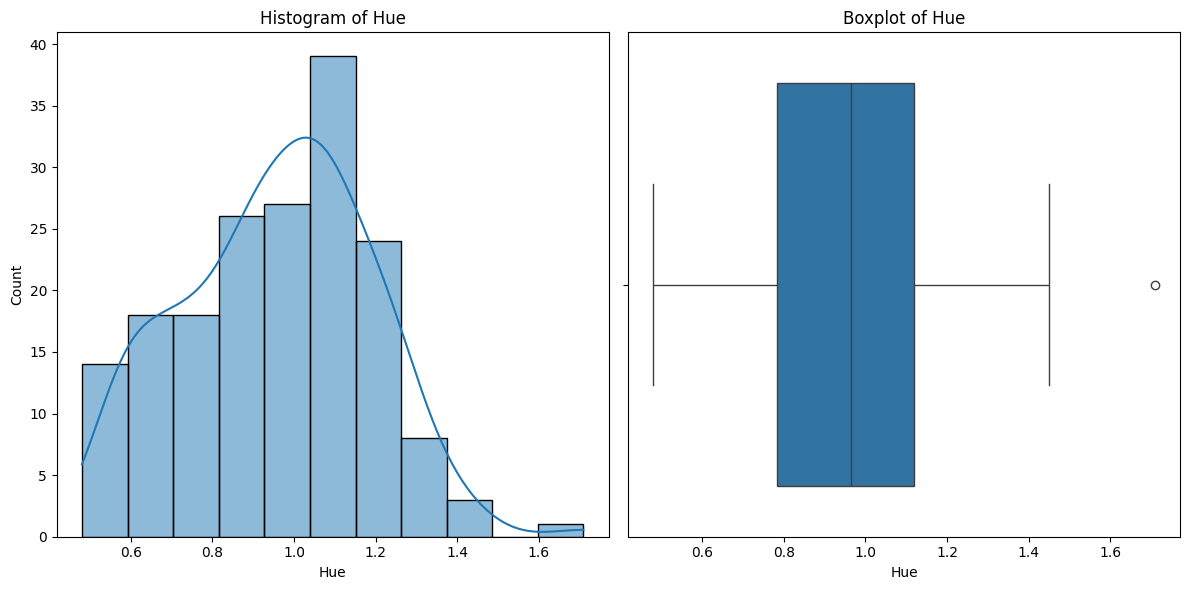

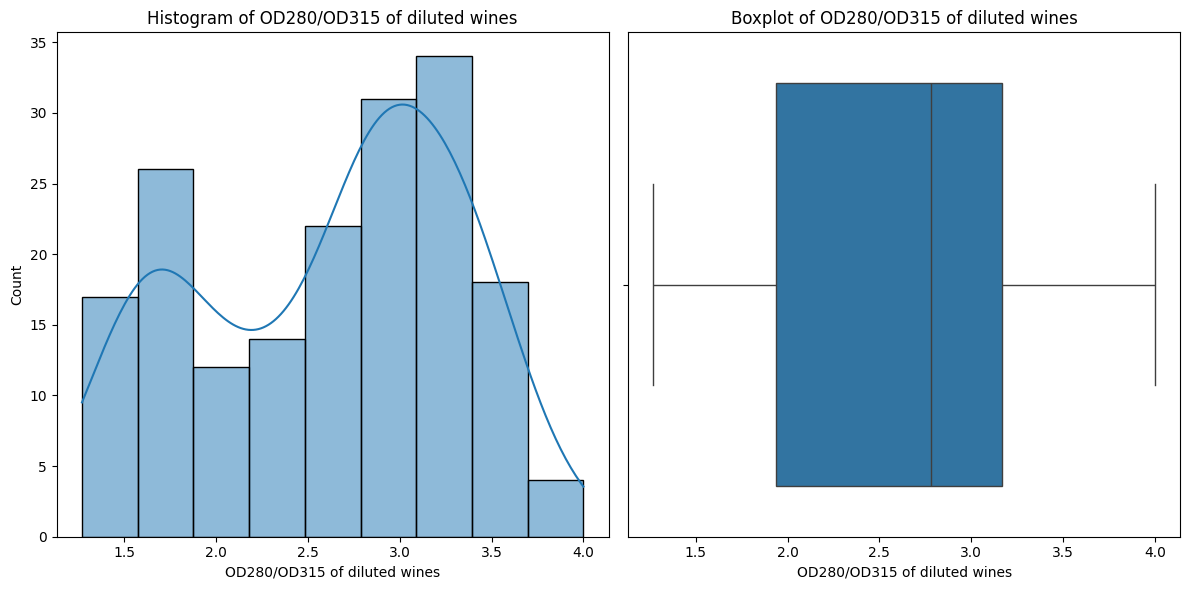

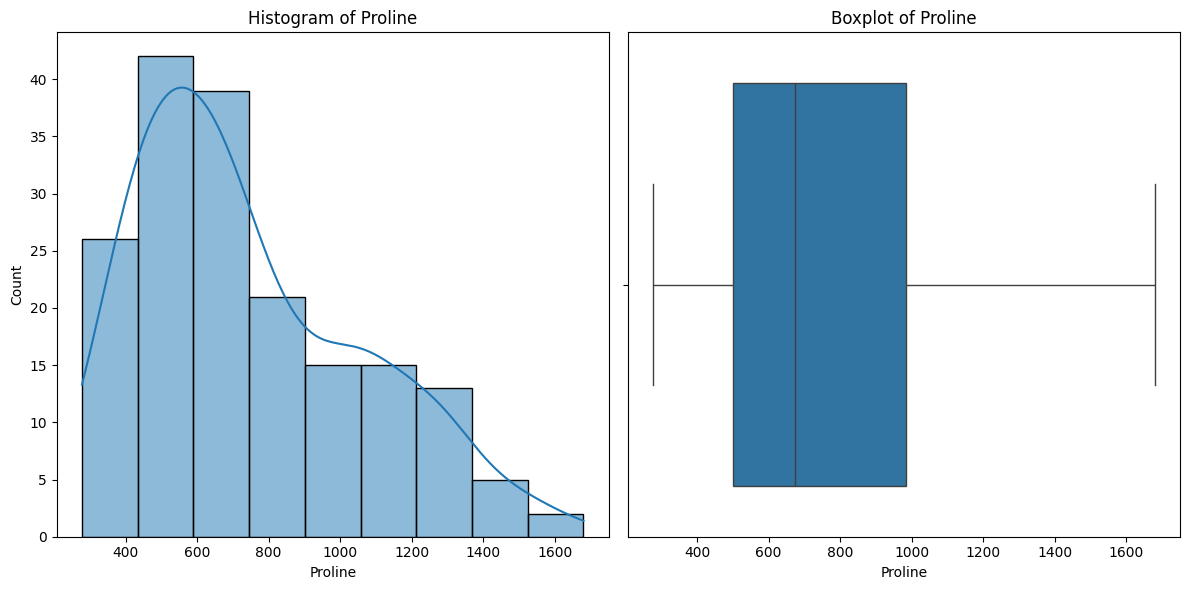

Accuracy: 0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00       0.0
       325.0       0.00      0.00      0.00       1.0
       342.0       0.00      0.00      0.00       1.0
       345.0       0.00      0.00      0.00       1.0
       372.0       0.00      0.00      0.00       1.0
       385.0       0.00      0.00      0.00       1.0
       434.0       0.00      0.00      0.00       1.0
       470.0       0.00      0.00      0.00       1.0
       480.0       0.00      0.00      0.00       1.0
       500.0       0.00      0.00      0.00       1.0
       502.0       0.00      0.00      0.00       1.0
       510.0       0.00      0.00      0.00       1.0
       564.0       0.00      0.00      0.00       1.0
       600.0       0.00      0.00      0.00       1.0
       615.0       0.00      0.00      0.00       1.0
       630.0 

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

column_names = [
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline"
]

model = KMeans()
params = {'n_clusters':[3]}
master(url,column_names=column_names, problem_type='classification',model=model, params=params)